# The Effect of Substance Use, Gender, Age, and Exercise on Sleep Quality

### Group member contributions

All work was done by Casey Martin, there were no other group members.

### Github repository

https://github.com/caseym7875/DSCI-235-Sleep-quality-final-project

# Introduction

Sleep is one of the most important functions of the body as it is necessary for maintaining both physical and mental health. Countless people suffer from various sleep disorders such as insomnia or who just experience low-quality sleep and end up being less healthy because of it. Lifestyle factors play a critical role in determining sleep quality, so studying which factors play the biggest roles and by how much is very important.

This analysis is on the Sleep Efficiency Dataset that was uploaded to Kaggle by the user Equilibriumm. The source of the data comes from a study done in Morocco by the university ENSIAS. This study recruited participants from their local community and collected self-reported surveys. They used the sleep monitoring technologies actigraphy and polysomnography to measure how much time they spent sleeping and what stage of sleep they were in.

The dataset includes columns corresponding to the age of the participants, their gender, the times they went to bed or woke up, whether or not they smoked, the amount of caffeine they consumed, and the amount of alcohol they consumed. The nicotine, caffeine, and alcohol use reported in the dataset is important to study as it is already known that those three negatively impact sleep. This analysis will look at how the various combinations of those substances can impact sleep.

The dataset also contains columns of the various metrics of sleep which are sleep efficiency: the proportion of time spent in bed actually sleeping, sleep duration: the total amount of time asleep, and the percent time spent in REM sleep, deep sleep, and light sleep, which are the three main phases of sleep. REM sleep (rapid eye movement sleep) is a phase characterized by rapid movement of the eyes and is when most dreams occur. Deep sleep makes up the greatest proportion of sleep and is characterized by slow brain waves. It is important for memory consolidation, growth, immune system regulation, and repair. Light sleep makes up the shortest proportion of sleep that mostly occurs at the beginning of sleep. Too much light sleep and too little deep and REM sleep is a sign of low sleep quality.

# Setup and preprocessing

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from opendatasets import download
from scipy.stats import ttest_ind, tukey_hsd, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression

### Downloading and loading dataset from kaggle

In [2]:
# Need to have kaggle account and API key.
dataset_url = 'https://www.kaggle.com/datasets/equilibriumm/sleep-efficiency'
download(dataset_url)

Skipping, found downloaded files in ".\sleep-efficiency" (use force=True to force download)


In [3]:
directory = '~\DSCI 235\Project\sleep-efficiency\sleep_efficiency.csv'
data = pd.read_csv(directory)
data

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,448,27,Female,2021-11-13 22:00:00,2021-11-13 05:30:00,7.5,0.91,22,57,21,0.0,0.0,0.0,No,5.0
448,449,52,Male,2021-03-31 21:00:00,2021-03-31 03:00:00,6.0,0.74,28,57,15,4.0,25.0,0.0,No,3.0
449,450,40,Female,2021-09-07 23:00:00,2021-09-07 07:30:00,8.5,0.55,20,32,48,1.0,NaN,3.0,Yes,0.0
450,451,45,Male,2021-07-29 21:00:00,2021-07-29 04:00:00,7.0,0.76,18,72,10,3.0,0.0,0.0,No,3.0


### Setting up functions

In [4]:
col_num = ['Age', 'Sleep duration', 'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage',
          'Light sleep percentage']
metric = ['Sleep efficiency', 'Sleep duration', 'REM sleep percentage', 
          'Deep sleep percentage', 'Light sleep percentage']

In [5]:
def histograms(comp):
    for col in metric:
        data_yes = data[data[comp] == 'Yes'][col]
        data_no = data[data[comp] == 'No'][col]
        plt.hist(data_yes,bins = 10, color='red',label='Yes',alpha=0.5)
        plt.hist(data_no,bins = 10, color='blue',label='No',alpha=0.5)
        plt.title(col+ ' by '+ comp)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

In [6]:
def boxplots(comp):
    for col in metric:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax = data.boxplot(column=col, by=comp, ax=ax)
        ax.set_title(col+' by '+comp)
        ax.set_xlabel(comp)
        ax.set_ylabel(col)
        plt.xticks(rotation=45)
        ax.grid(False)
        plt.show()

In [7]:
# Calculate Cohen's d effect size.
def cohen_d(x, y):
    n1, n2 = len(x), len(y)
    s1, s2 = np.var(x, ddof=1), np.var(y, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    return (np.mean(x) - np.mean(y)) / s

In [8]:
# For calculating t-tests.
def tests(comp):
    for col in metric:
        _, p_value = ttest_ind(data[data[comp]=='Yes'][col], 
              data[data[comp]=='No'][col],
             equal_var = False)
        effect_size = cohen_d(data[data[comp]=='Yes'][col], 
        data[data[comp]=='No'][col])
        print(f"{col}\np-value: {p_value:.6f}")
        print(f"Cohen's d: {effect_size:.4f}\n")

In [9]:
# Scatterplots with regression line and R^2
def scatters_cont(comp):
    for col in metric:
        model = LinearRegression().fit(data[[comp]], data[col])
        plt.scatter(data[comp], data[col])
        X_pred = np.linspace(data[comp].min(), data[comp].max(), 100).reshape((-1, 1))
        y_pred = model.predict(X_pred)
        plt.plot(X_pred, y_pred, color='red')
        plt.xlabel(comp)
        plt.ylabel(col)
        plt.title(comp+' by '+col)
        plt.show()
        r_sq = model.score(data[[comp]], data[col])
        print(col)
        print(f"R^2: {r_sq:.4f}\n")

In [10]:
# Same as scatters_cont but without loop.
def scatter_select(comp, col):
    model = LinearRegression().fit(data[[comp]], data[col])
    plt.scatter(data[comp], data[col])
    X_pred = np.linspace(data[comp].min(), data[comp].max(), 100).reshape((-1, 1))
    y_pred = model.predict(X_pred)
    plt.plot(X_pred, y_pred, color='red')
    plt.xlabel(comp)
    plt.ylabel(col)
    plt.title(comp+' by '+col)
    plt.show()
    r_sq = model.score(data[[comp]], data[col])
    print(comp+' by '+col)
    print(f"R^2: {r_sq:.4f}\n")

In [11]:
def cal_r_sqrd(comp):
    for col in metric:
        model = LinearRegression().fit(data[[comp]], data[col])
        r_sq = model.score(data[[comp]], data[col])
        print(col)
        print(f"R^2: {r_sq:.4f}\n")

### Remove rows with NAs

In [12]:
for col in data.columns:
    print(col,' ', data[col].isna().sum())

ID   0
Age   0
Gender   0
Bedtime   0
Wakeup time   0
Sleep duration   0
Sleep efficiency   0
REM sleep percentage   0
Deep sleep percentage   0
Light sleep percentage   0
Awakenings   20
Caffeine consumption   25
Alcohol consumption   14
Smoking status   0
Exercise frequency   6


In [13]:
data.dropna(inplace=True)

### Dataframe setup

In [14]:
data['Caffeine status'] = np.where(data['Caffeine consumption'] > 0, 'Yes', 'No')
data['Alcohol status'] = np.where(data['Alcohol consumption'] > 0, 'Yes', 'No')

data_multi = data.set_index(['Smoking status', 'Caffeine status', 'Alcohol status'])
data_multi

ID  Age  Gender  \
Smoking status Caffeine status Alcohol status                     
Yes            No              No                1   65  Female   
                               Yes               2   69    Male   
No             No              No                3   40  Female   
Yes            Yes             Yes               4   40  Female   
No             No              Yes               5   57    Male   
...                                            ...  ...     ...   
Yes            Yes             Yes             446   30  Female   
No             No              No              448   27  Female   
               Yes             No              449   52    Male   
               No              No              451   45    Male   
               Yes             No              452   18    Male   

                                                           Bedtime  \
Smoking status Caffeine status Alcohol status                        
Yes            No              No              2021-03-06 01:00:00   
                               Yes             2021-12-05 02:00:00   
No             No              No              2021-05-25 21:30:00   
Yes            Yes             Yes             2021-11-03 02:30:00   
No             No              Yes             2021-03-13 01:00:00   
...                                                            ...   
Yes            Yes             Yes             2021-11-16 23:00:00   
No             No              No              2021-11-13 22:00:00   
               Yes             No              2021-03-31 21:00:00   
               No              No              2021-07-29 21:00:00   
               Yes             No              2021-03-17 02:30:00   

                                                       Wakeup time  \
Smoking status Caffeine status Alcohol status                        
Yes            No              No              2021-03-06 07:00:00   
                               Yes             2021-12-05 09:00:00   
No             No              No              2021-05-25 05:30:00   
Yes            Yes             Yes             2021-11-03 08:30:00   
No             No              Yes             2021-03-13 09:00:00   
...                                                            ...   
Yes            Yes             Yes             2021-11-16 06:30:00   
No             No              No              2021-11-13 05:30:00   
               Yes             No              2021-03-31 03:00:00   
               No              No              2021-07-29 04:00:00   
               Yes             No              2021-03-17 10:00:00   

                                               Sleep duration  \
Smoking status Caffeine status Alcohol status                   
Yes            No              No                         6.0   
                               Yes                        7.0   
No             No              No                         8.0   
Yes            Yes             Yes                        6.0   
No             No              Yes                        8.0   
...                                                       ...   
Yes            Yes             Yes                        7.5   
No             No              No                         7.5   
               Yes             No                         6.0   
               No              No                         7.0   
               Yes             No                         7.5   

                                               Sleep efficiency  \
Smoking status Caffeine status Alcohol status                     
Yes            No              No                          0.88   
                               Yes                         0.66   
No             No              No                          0.89   
Yes            Yes             Yes                         0.51   
No             No              Yes                         0.76   
...                                    

The original dataset included a column named "Smoking status" but it did not include similar columns to indicate the use of caffeine or alcohol. It did include how much caffeine and alcohol was consumed, so two new columns were created to indicate if participants consumed any of either substance.

These status values were used as multi-index columns to group participants into each combination of substances consumed.

# Histograms of numeric columns

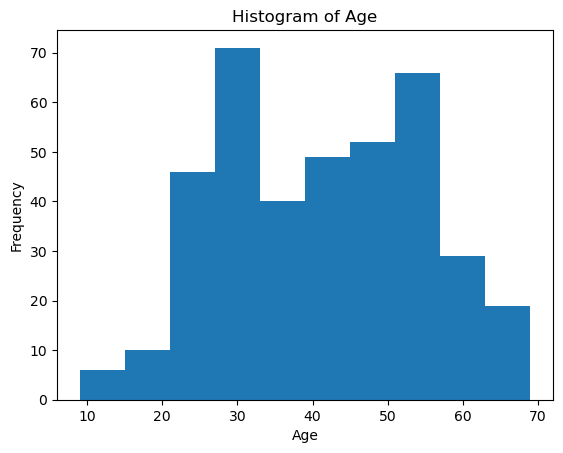

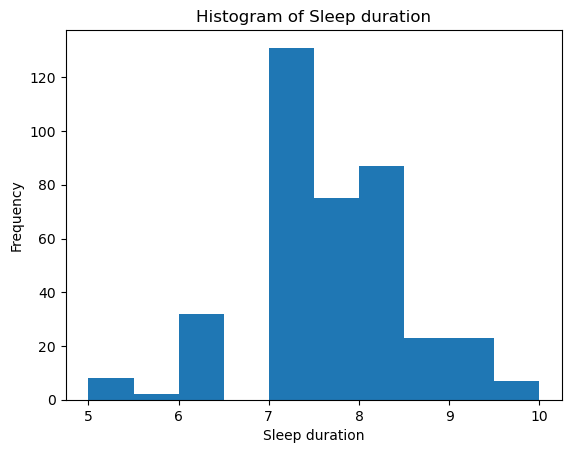

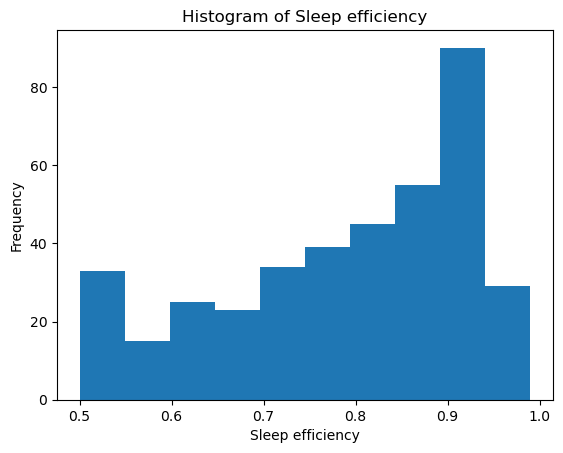

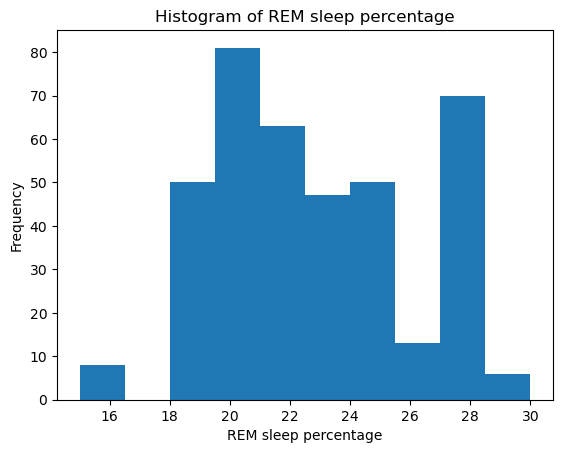

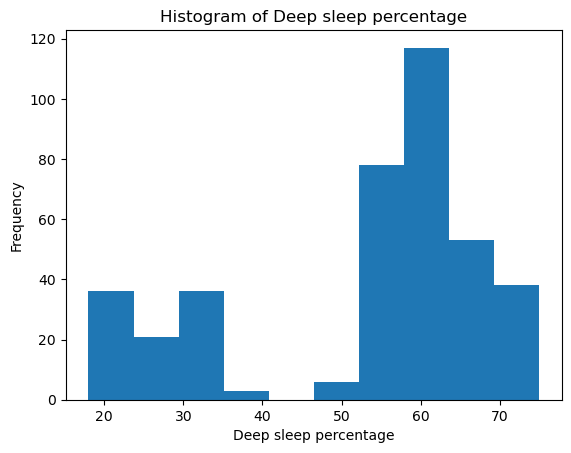

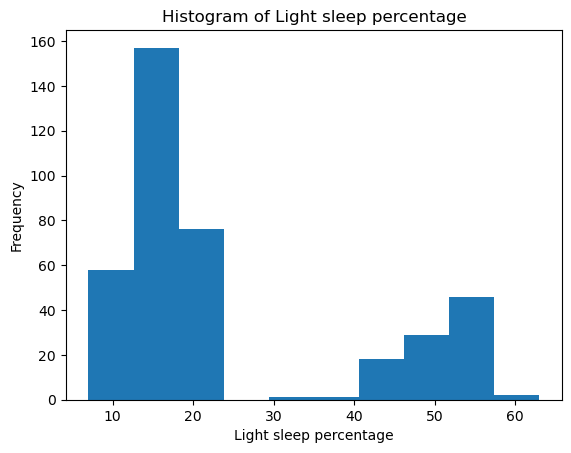

In [15]:
for col in col_num:
    data[col].hist(bins=10)
    plt.title('Histogram of '+col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()

Histograms were generated to get an idea of the shape and normalness of the numeric columns.

Age, Sleep duration, and REM sleep percentage look approximately normal. Sleep efficiency is right skewed. Both deep sleep percentage and light sleep percentage are split in the middle, although there is a greater proportion of people spending a lot of time in deep sleep and a similar proportion spending a small amount of time in light sleep.

The fact that sleep efficiency is right skewed makes sense considering most people sleep well at night. The reason for the split between deep sleep and light sleep is interesting. The smaller group spending more time in light sleep and less time in deep sleep might have bad sleep quality.

# Sleep metric correlations

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


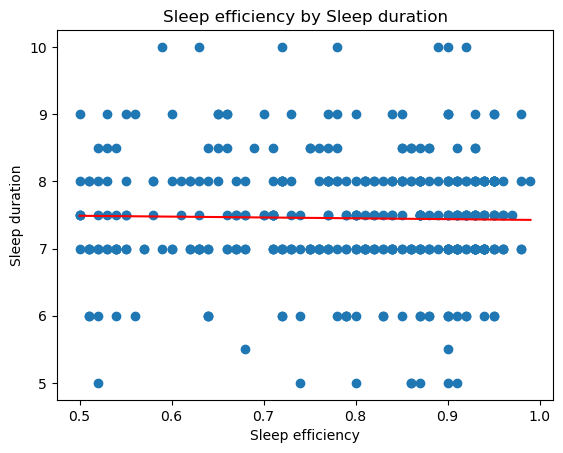

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Sleep efficiency by Sleep duration
R^2: 0.0004



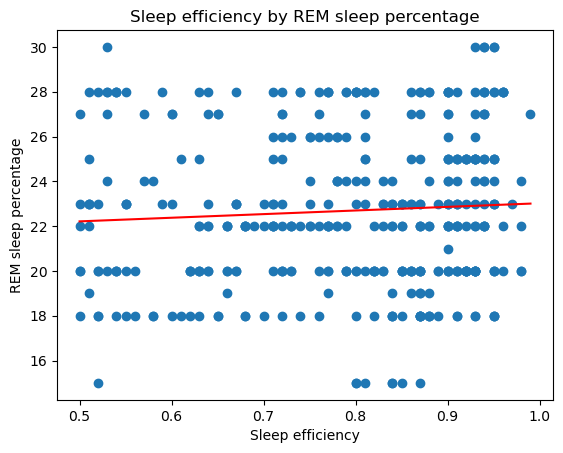

Sleep efficiency by REM sleep percentage
R^2: 0.0041



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


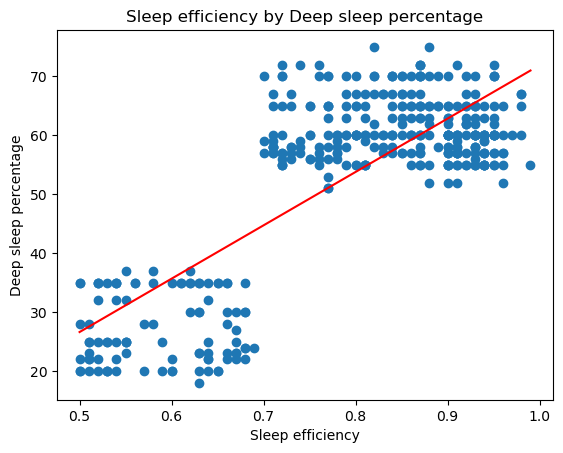

Sleep efficiency by Deep sleep percentage
R^2: 0.6227



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


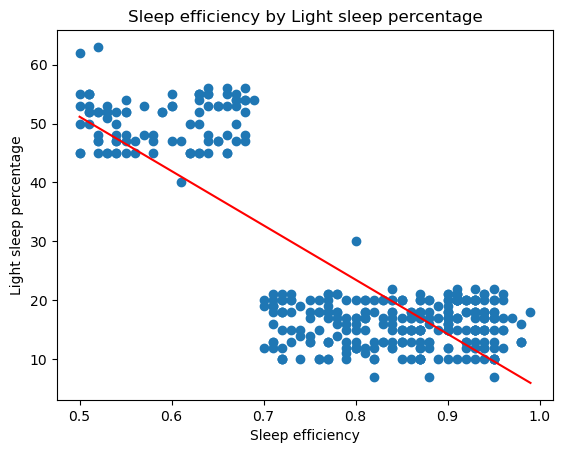

Sleep efficiency by Light sleep percentage
R^2: 0.6674



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


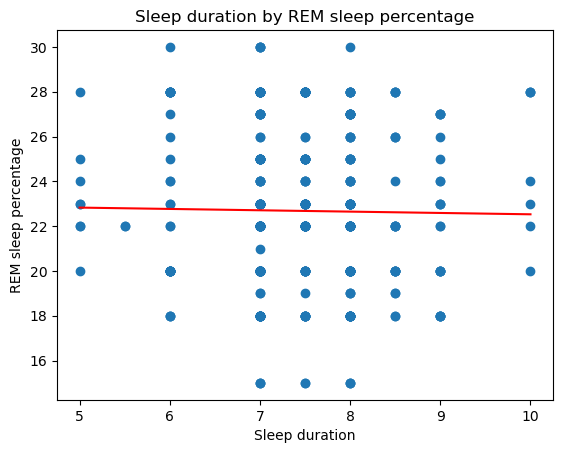

Sleep duration by REM sleep percentage
R^2: 0.0002



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


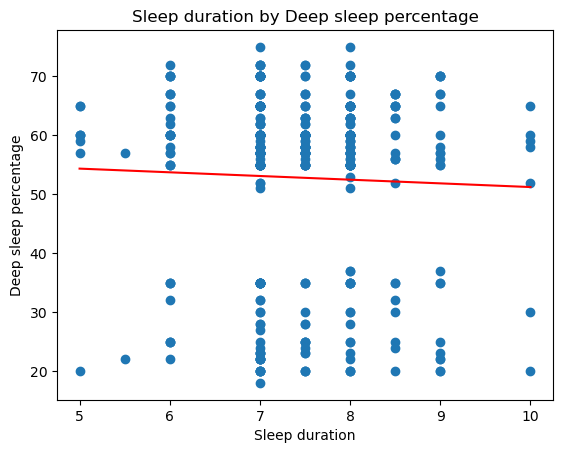

Sleep duration by Deep sleep percentage
R^2: 0.0013



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


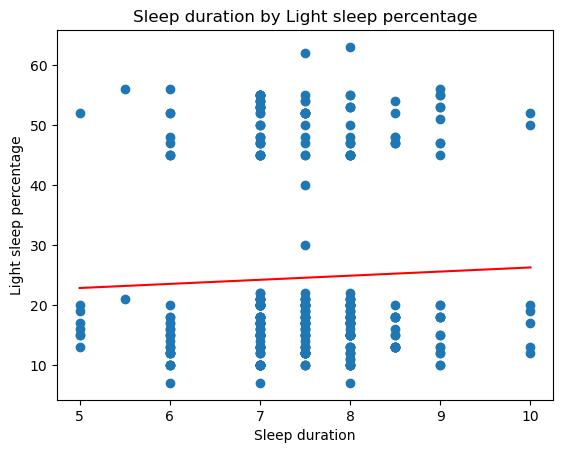

Sleep duration by Light sleep percentage
R^2: 0.0016



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


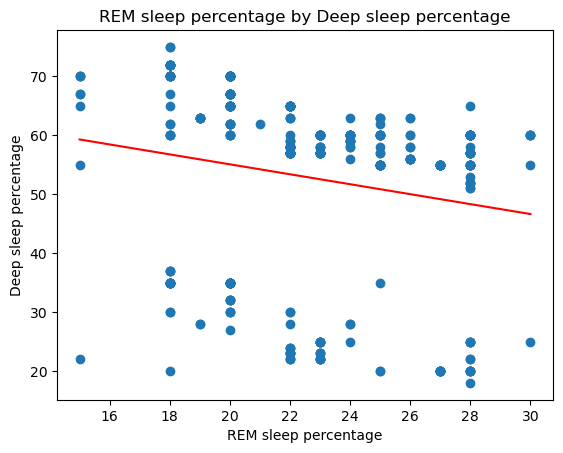

REM sleep percentage by Deep sleep percentage
R^2: 0.0345



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


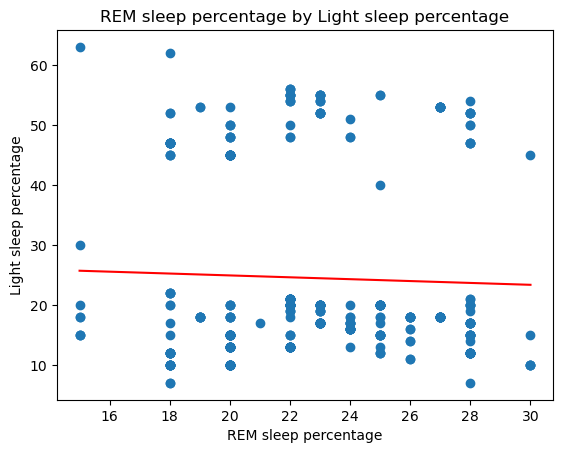

REM sleep percentage by Light sleep percentage
R^2: 0.0012



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


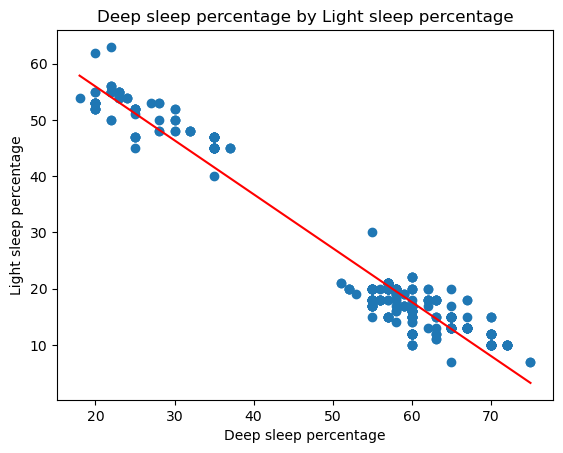

Deep sleep percentage by Light sleep percentage
R^2: 0.9515



In [16]:
scatter_select('Sleep efficiency', 'Sleep duration')
scatter_select('Sleep efficiency', 'REM sleep percentage')
scatter_select('Sleep efficiency', 'Deep sleep percentage')
scatter_select('Sleep efficiency', 'Light sleep percentage')

scatter_select('Sleep duration', 'REM sleep percentage')
scatter_select('Sleep duration', 'Deep sleep percentage')
scatter_select('Sleep duration', 'Light sleep percentage')

scatter_select('REM sleep percentage', 'Deep sleep percentage')
scatter_select('REM sleep percentage', 'Light sleep percentage')

scatter_select('Deep sleep percentage', 'Light sleep percentage')

Scatterplots and R^2 values were created to look at the associations of the various sleep metrics among themselves. Of these, the correlations that stand out are sleep efficiency with deep sleep (R^2 = 0.62), sleep efficiency with light sleep (R^2 = 0.67), REM sleep with deep sleep (R^2 = 0.04), and deep sleep with light sleep (R^2 = 0.95).

Deep sleep and light sleep have a strong negative correlation with each other where more time spent in deep sleep means less time is spent in light sleep. This makes sense since both variables are the proportion of the total time asleep that they are in one of those states, so someone who spends a lot of time in deep sleep doesn't have as much time to spend in other states of sleep. It is interesting that REM sleep has a very weak negative correlation with deep sleep and no correlation with light sleep.

It is interesting that sleep efficiency has a strong positive association with deep sleep and a strong negative association with light sleep, indicating that deep sleep is important for having high-quality sleep. It is surprising that sleep duration does not correlate strongly with any other metric.

# Substance combinations

### Boxplots

C:\Users\Atomi\AppData\Local\Temp\ipykernel_26704\1055056136.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  box_data = [data_multi.loc[combination, col] for combination in combinations]


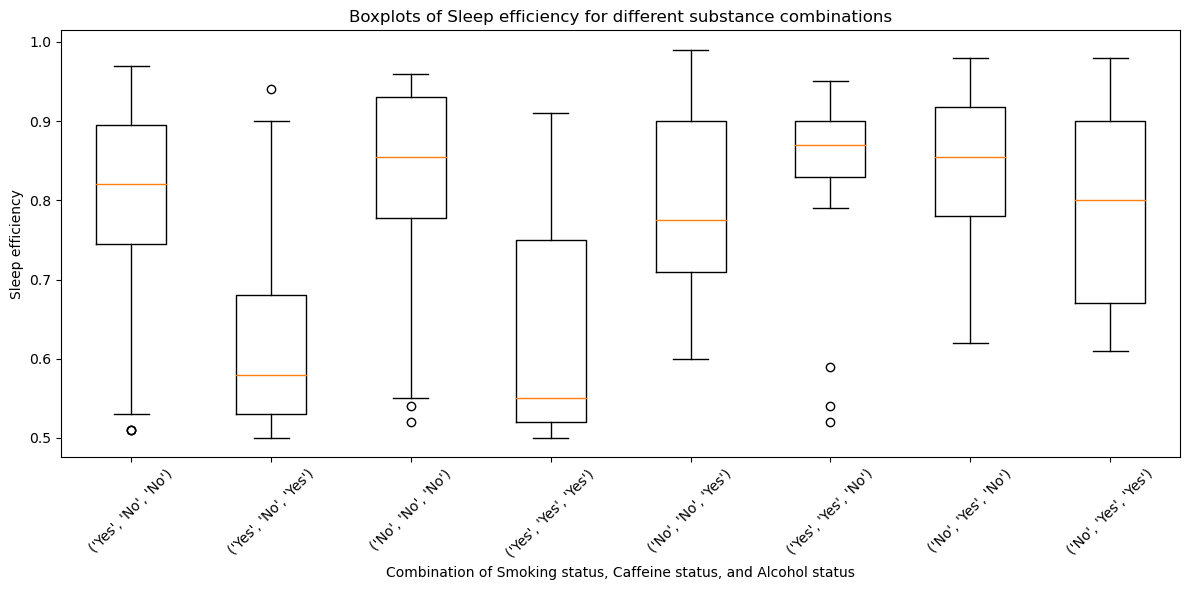

C:\Users\Atomi\AppData\Local\Temp\ipykernel_26704\1055056136.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  box_data = [data_multi.loc[combination, col] for combination in combinations]


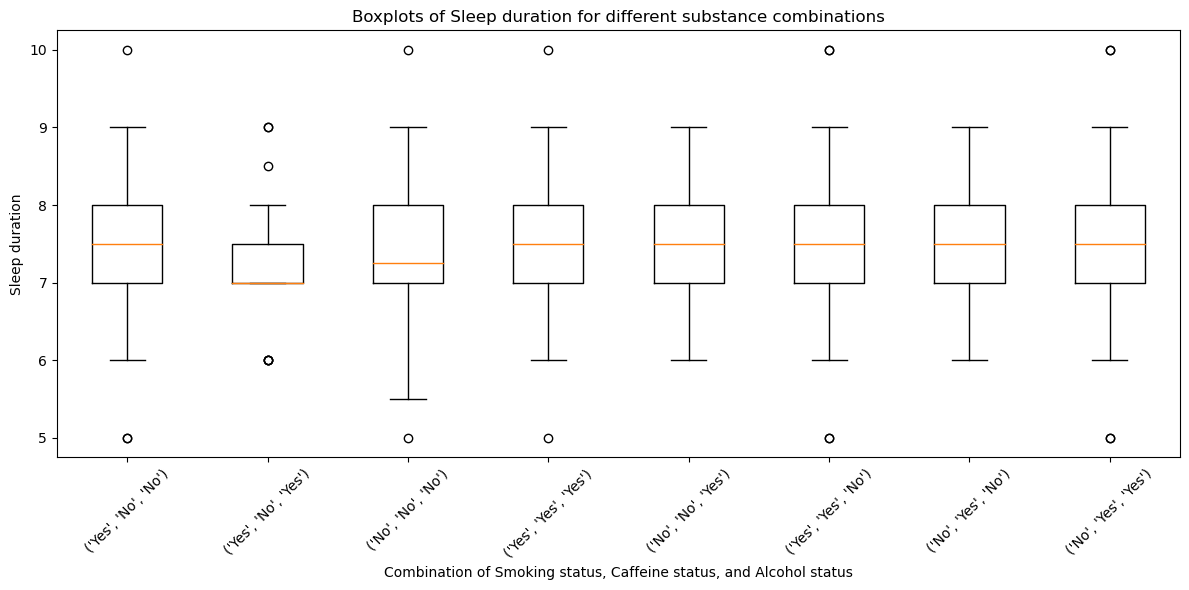

C:\Users\Atomi\AppData\Local\Temp\ipykernel_26704\1055056136.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  box_data = [data_multi.loc[combination, col] for combination in combinations]


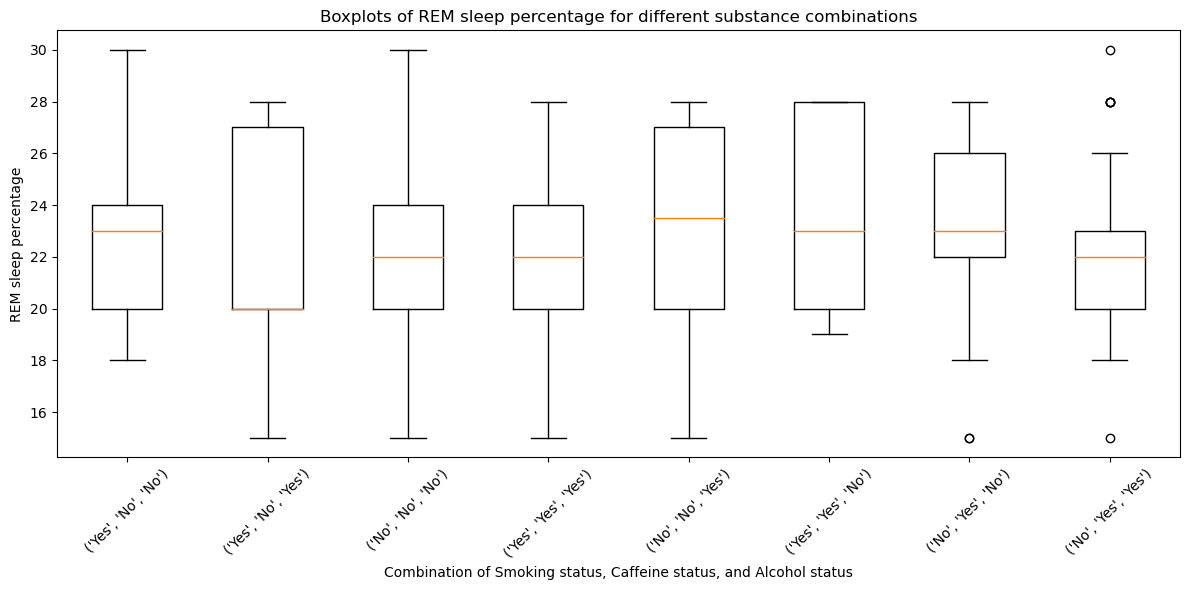

C:\Users\Atomi\AppData\Local\Temp\ipykernel_26704\1055056136.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  box_data = [data_multi.loc[combination, col] for combination in combinations]


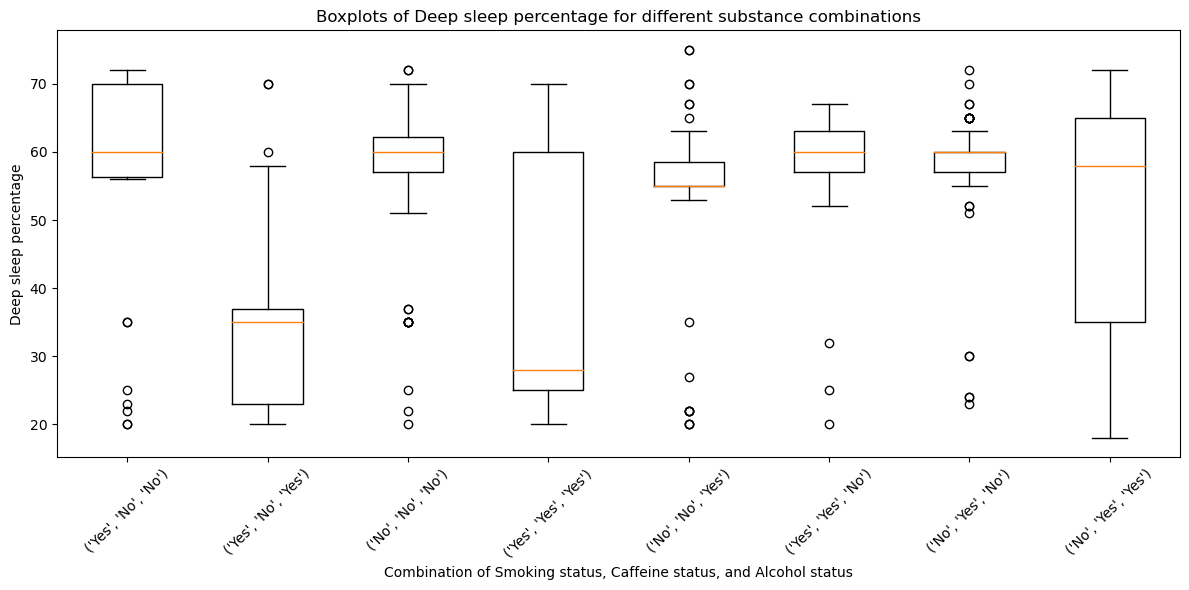

C:\Users\Atomi\AppData\Local\Temp\ipykernel_26704\1055056136.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  box_data = [data_multi.loc[combination, col] for combination in combinations]


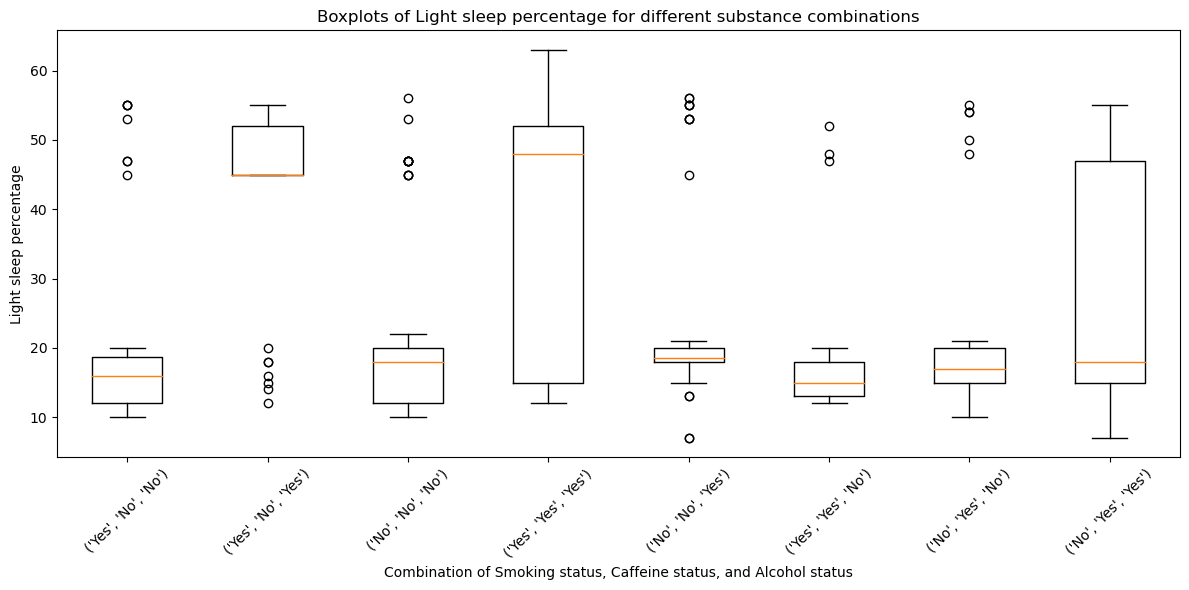

In [17]:
combinations = data_multi.index.unique()
for col in metric:

    fig, ax = plt.subplots(figsize=(12, 6))
    positions = range(1, len(combinations) + 1)

    box_data = [data_multi.loc[combination, col] for combination in combinations]
    ax.boxplot(box_data, positions=positions, widths=0.5)
    ax.set_xticks(positions)
    ax.set_xticklabels([str(combination) for combination in combinations], rotation=45)
    ax.set_xlabel('Combination of Smoking status, Caffeine status, and Alcohol status')
    ax.set_ylabel(col)
    ax.set_title('Boxplots of '+col+' for different substance combinations')
    plt.tight_layout()
    plt.show()

Boxplots were generated for each combination of whether or not the three substances had been consumed prior to this study.

Sleep efficiency shows boxplots that are quite different from each other, while sleep duration doesn't seem to be very different. The case of consuming cigarettes and alcohol but not caffeine as well as the case of consuming all three stand out as being much lower than the other boxes, indicating that the combination of these substances is particularly detrimental to sleep quality.

The boxes for REM sleep do not show much differences from each other.

The boxes for deep sleep and light sleep are interesting as they both contain massive amounts of outliers above or below the boxes. These outliers are due to the split distribution seen earlier, so they aren't really outliers, more just an artifact of the shape of the data. The combinations of smoking with alcohol, and all three substances stand out as spending less time in deep sleep and more time in light sleep. These are the same groups that had low sleep efficiency, indicating that there is a connection here.

### Statistical tests

In [18]:
combinations = data_multi.index.unique()
all_no = combinations[2]

p_values = []
cohens_ds = []
comparisons = []
metrics_display = []

for col in metric:
    all_no_metric = data_multi.loc[all_no, col]
    for combination in combinations:
        if combination != all_no:
            metric_ = data_multi.loc[combination, col]

            _, p_value = ttest_ind(all_no_metric, metric_)
            effect_size = cohen_d(all_no_metric, metric_)
            
            p_values.append(p_value)
            cohens_ds.append(effect_size)
            comparisons.append(combination)
            metrics_display.append(col)
            
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
significant_indices = np.where(corrected_p_values < 0.05)[0]

for i in significant_indices:
    print(metrics_display[i])
    print(f"Comparing {all_no} vs {comparisons[i]}:")
    print(f"FDR-corrected p-value: {corrected_p_values[i]:.4f}")
    print(f"Cohen's d: {cohens_ds[i]:.4f}\n")


Sleep efficiency
Comparing ('No', 'No', 'No') vs ('Yes', 'No', 'Yes'):
FDR-corrected p-value: 0.0000
Cohen's d: 1.6644

Sleep efficiency
Comparing ('No', 'No', 'No') vs ('Yes', 'Yes', 'Yes'):
FDR-corrected p-value: 0.0000
Cohen's d: 1.6206

REM sleep percentage
Comparing ('No', 'No', 'No') vs ('Yes', 'Yes', 'No'):
FDR-corrected p-value: 0.0110
Cohen's d: -0.6178

REM sleep percentage
Comparing ('No', 'No', 'No') vs ('No', 'Yes', 'No'):
FDR-corrected p-value: 0.0273
Cohen's d: -0.4565

Deep sleep percentage
Comparing ('No', 'No', 'No') vs ('Yes', 'No', 'Yes'):
FDR-corrected p-value: 0.0000
Cohen's d: 1.6889

Deep sleep percentage
Comparing ('No', 'No', 'No') vs ('Yes', 'Yes', 'Yes'):
FDR-corrected p-value: 0.0000
Cohen's d: 1.3100

Deep sleep percentage
Comparing ('No', 'No', 'No') vs ('No', 'Yes', 'Yes'):
FDR-corrected p-value: 0.0300
Cohen's d: 0.4577

Light sleep percentage
Comparing ('No', 'No', 'No') vs ('Yes', 'No', 'Yes'):
FDR-corrected p-value: 0.0000
Cohen's d: -1.6633

Light s

C:\Users\Atomi\AppData\Local\Temp\ipykernel_26704\1534756315.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_no_metric = data_multi.loc[all_no, col]
C:\Users\Atomi\AppData\Local\Temp\ipykernel_26704\1534756315.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  metric_ = data_multi.loc[combination, col]


T-tests were done specifically to compare the case for consuming no substances to the different combinations of substances for each of the sleep metrics. This was done instead of pairwise comparisons because pairwise comparisons would do too many tests. What is most interesting to study is which combinations of substances significantly impair sleep, but not which combinations of substances are different from each other in regards to their effect on sleep.

Since testing the differences between no substances and the different combinations for each metric still involves many tests, FDR multiple comparisons were done to correct p-values and reduce the incidence of type-I errors. 

Cohen's d values were calculated to see how strong the effect of the different combinations is. Only significant results are shown.

Sleep efficiency: 
The cases yes, no, yes (order is smoking, caffeine, alcohol) (d = 1.66) and yes, yes, yes (d = 1.62) were significant, which is consistent with the most prominently different boxes identified. These Cohen's d values are large, indicating a strong effect.

REM sleep:
The cases yes, yes, no (d = -0.62) and no, yes, no (d = -0.46) were significant. The Cohen's d values are of medium size and negative, indicating that these combinations increased time spent in REM sleep.

Deep sleep:
The cases yes, no, yes (d = 1.69), yes, yes, yes (d = 1.31), and no, yes, yes (d = 0.46) were significant. The first two have strong effect sizes while the last one is a medium effect size. Since they are all positive, these combinations of substances decreased the time spent in deep sleep.

Light sleep:
The cases yes, no, yes (d = -1.66), yes, yes, yes (d = -1.27), and no, yes, yes (d = -0.47) were significant. The first two have strong effect sizes while the third has a medium effect size. All are negative indicating more time spent in light sleep. 


These results suggest that combinations of substances do have a strong influence on sleep. There were two groups that were common among all but REM sleep which are yes, no, yes, and yes, yes, yes. This indicates that combining smoking and alcohol, or all three has a particularly strong impact on sleep. It is interesting that the two combinations that increased REM sleep didn't impact any of the other metrics.

# Smoking

### Histograms

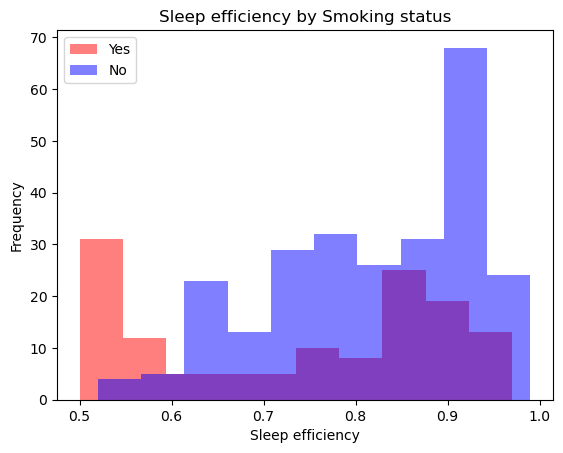

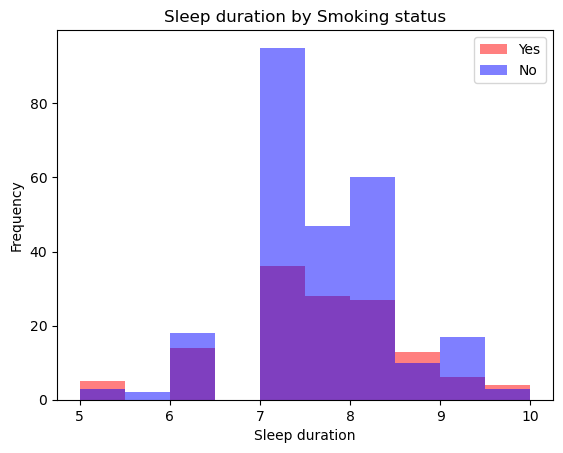

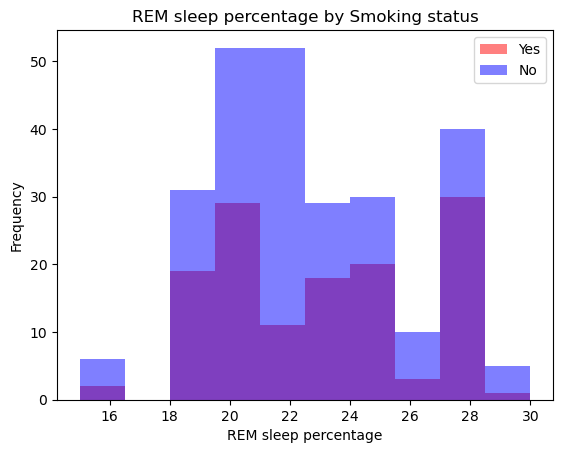

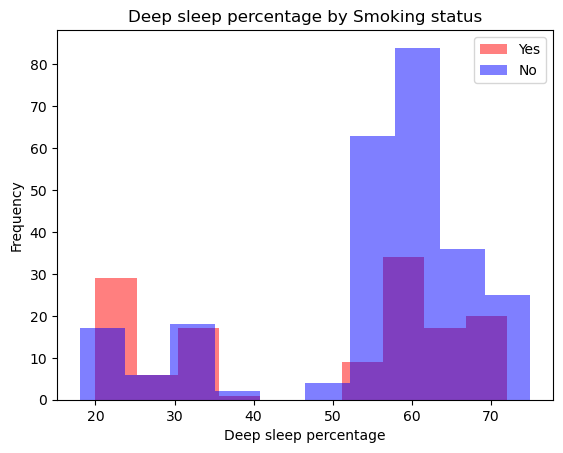

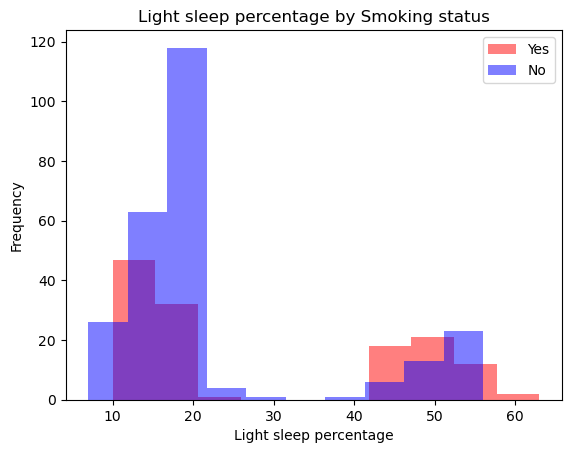

In [19]:
histograms('Smoking status')

The histograms of smoking status for sleep efficiency are different in that the distribution of people who are smokers is skewed towards having less sleep efficiency. The rest of the metrics mostly overlap between the two conditions.

### Boxplots

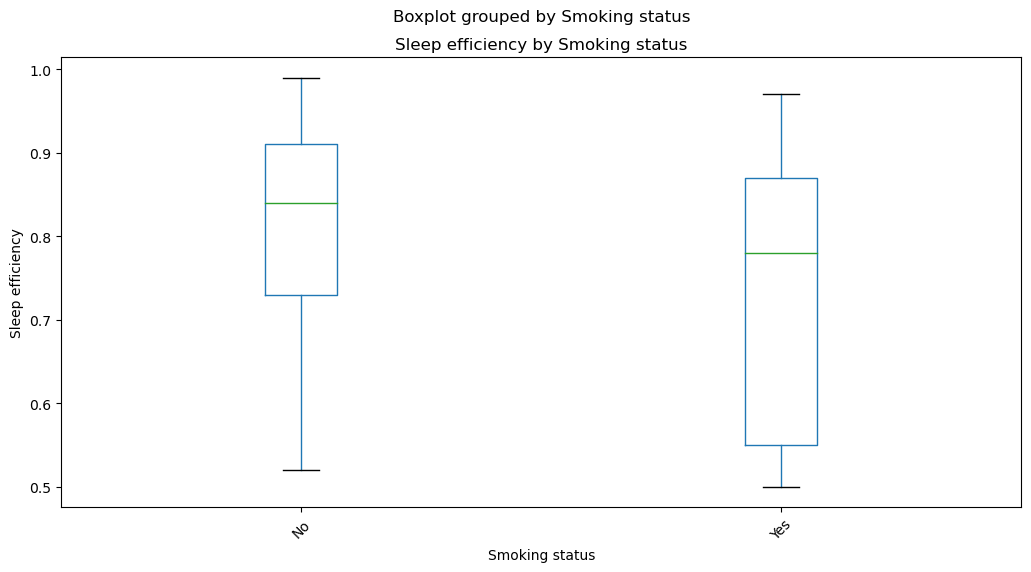

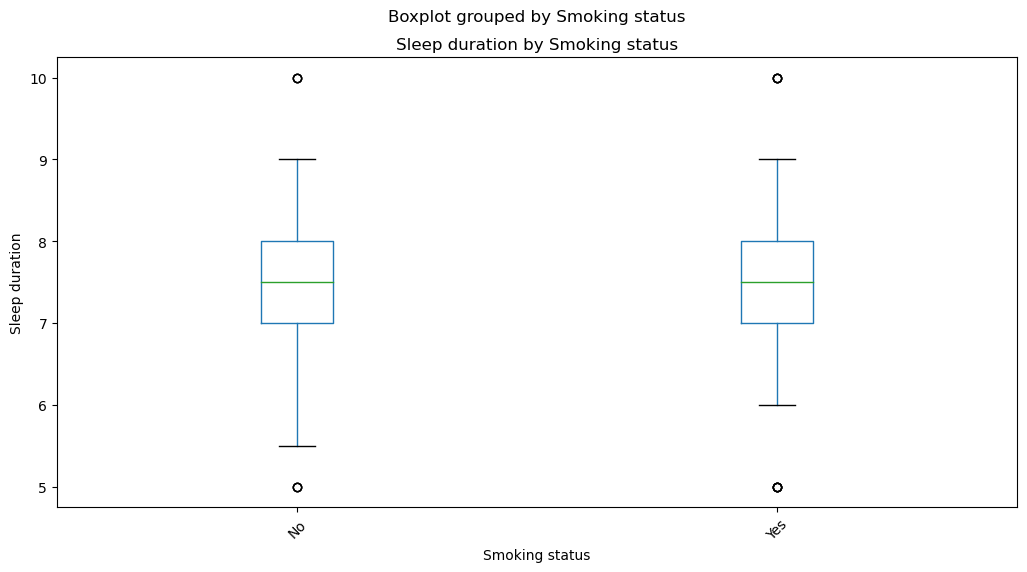

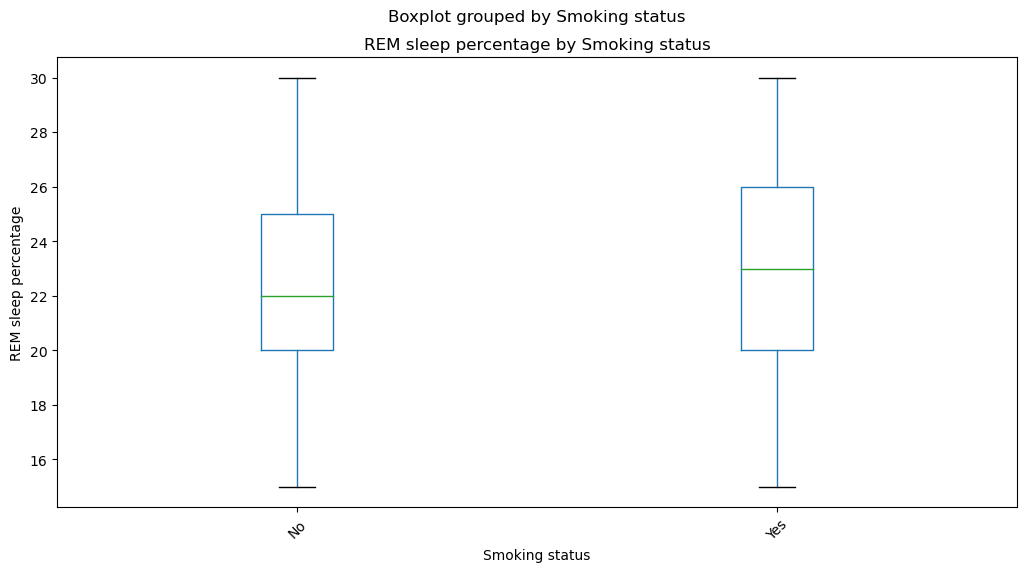

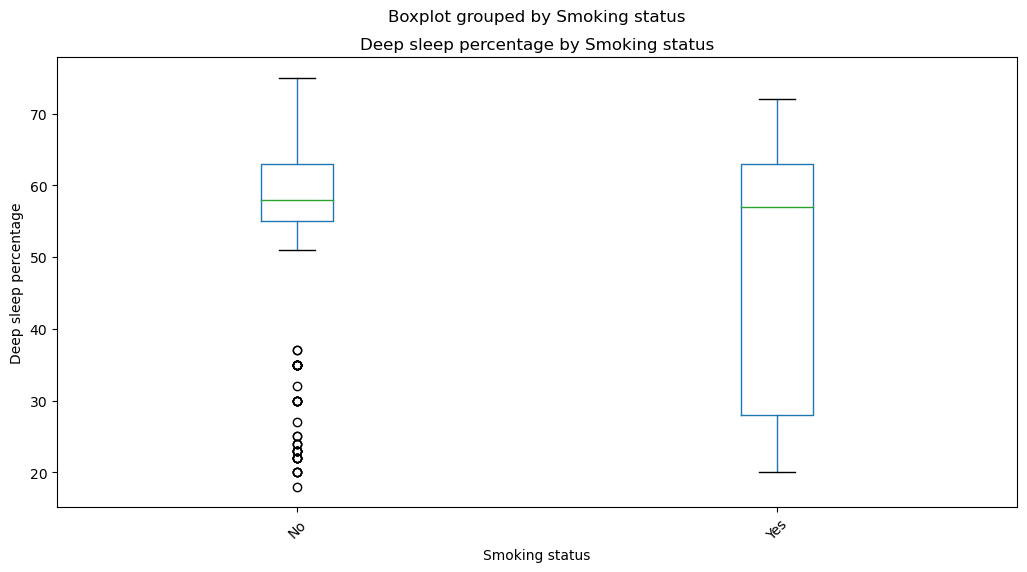

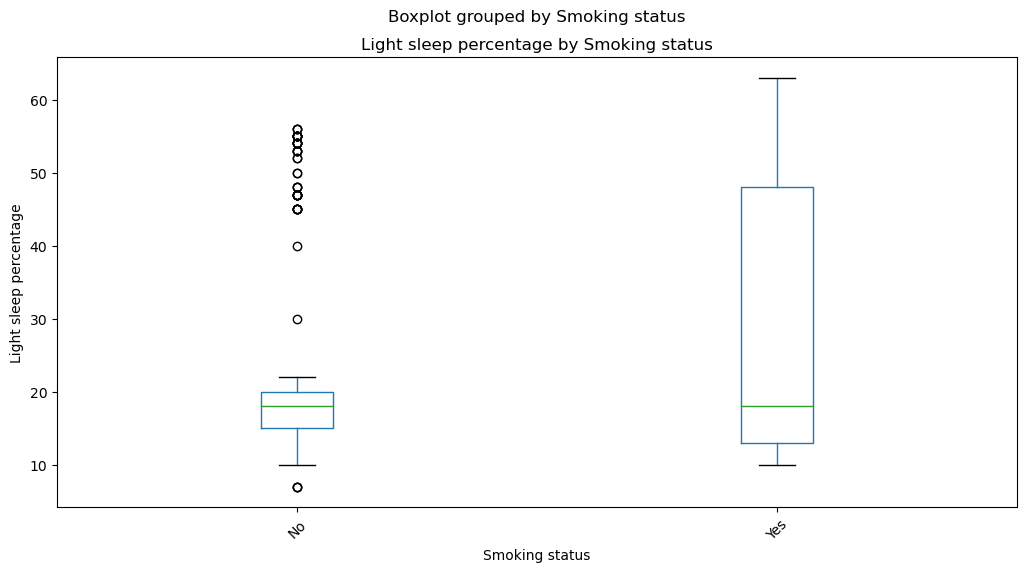

In [20]:
boxplots('Smoking status')

The boxplot for sleep efficiency shows that people who smoke have slightly less sleep efficiency, although there appears to be a lot of variability. Sleep duration appears similar between the two cases. People who smoke possibly spend slightly more time in REM sleep. It is hard to draw any conclusions for light and deep sleep due to the split distribution, but the similarity of the median lines suggests not much of a difference.

### Statistical tests

In [21]:
tests('Smoking status')

Sleep efficiency
p-value: 0.000000
Cohen's d: -0.6437

Sleep duration
p-value: 0.953378
Cohen's d: 0.0066

REM sleep percentage
p-value: 0.451057
Cohen's d: 0.0817

Deep sleep percentage
p-value: 0.000120
Cohen's d: -0.4584

Light sleep percentage
p-value: 0.000164
Cohen's d: 0.4470



The effect of smoking status on sleep efficiency is statistically significant with a somewhat high Cohen's d value of -0.64, suggesting that smokers have less sleep efficiency.

The effect on deep sleep percentage was also significant with a medium effect size of -0.46 suggesting that smokers spend less time in deep sleep. 

The effect on light sleep is also significant with a medium effect size of 0.45, suggesting that smokers spend more time in light sleep.

It is worth noting that the lack of significance for REM sleep is in contrast to what was observed with the boxplot.

### Conclusion

Smokers are associated with having lower quality sleep due to experiencing lower sleep efficiency and more time in light sleep compared to deep sleep.

# Caffeine

### Histograms

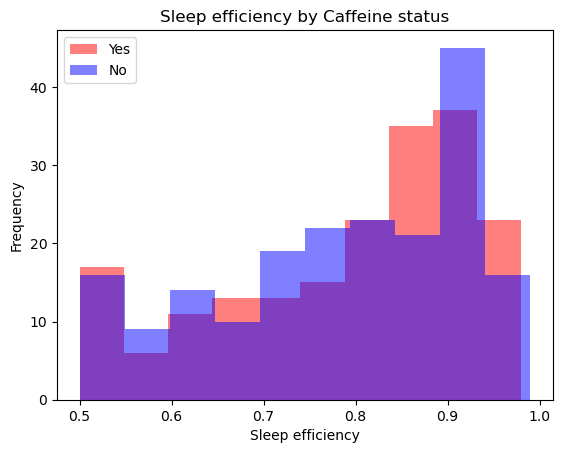

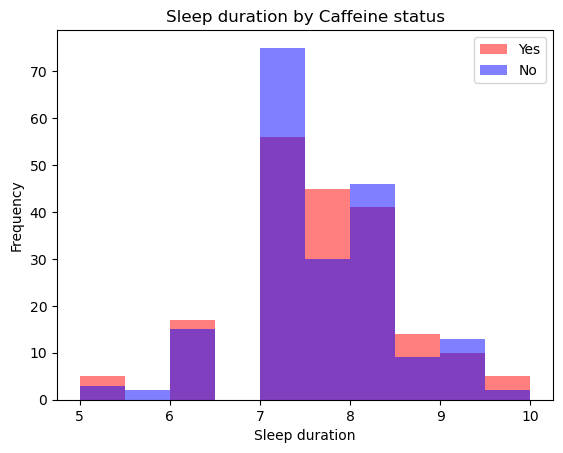

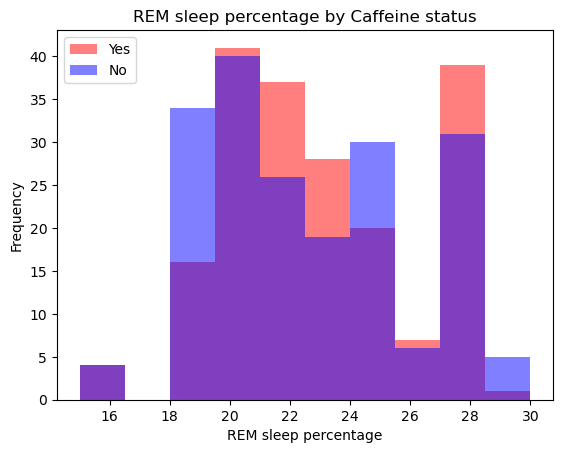

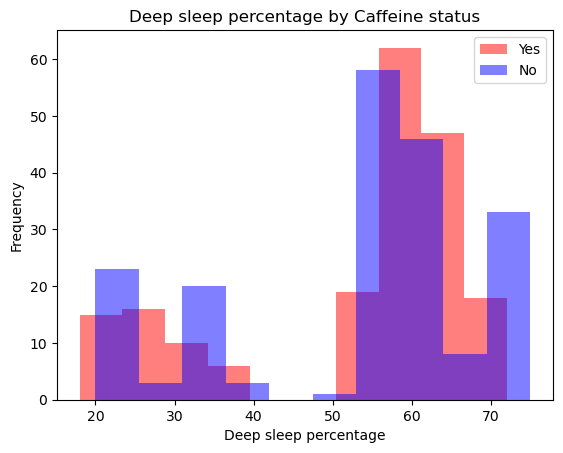

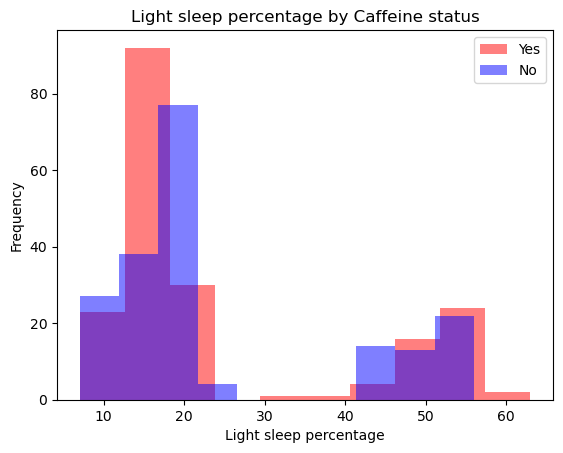

In [22]:
histograms('Caffeine status')

There is a strong degree of overlap between the two caffeine conditions for all metrics, suggesting little difference.

### Boxplots

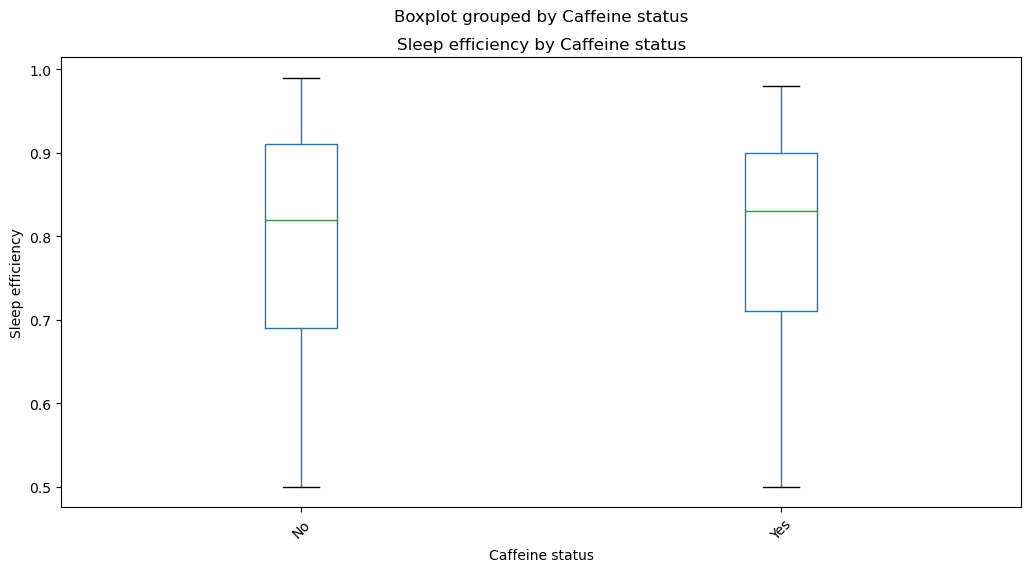

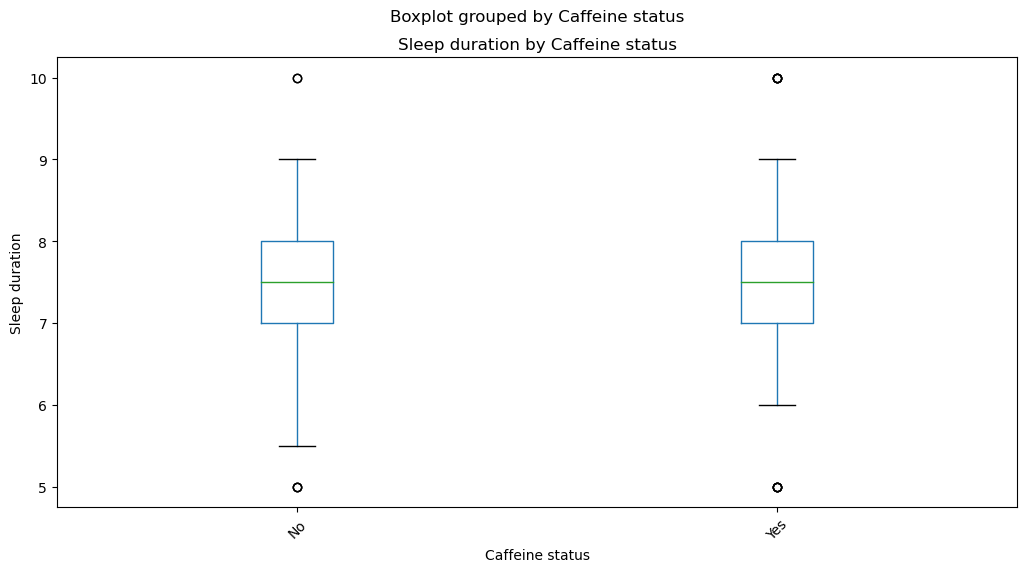

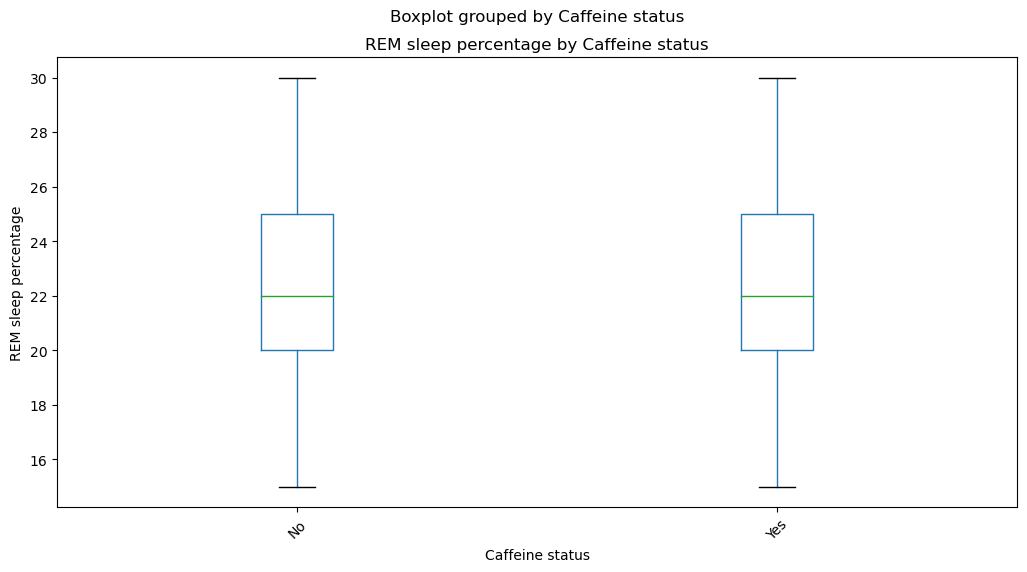

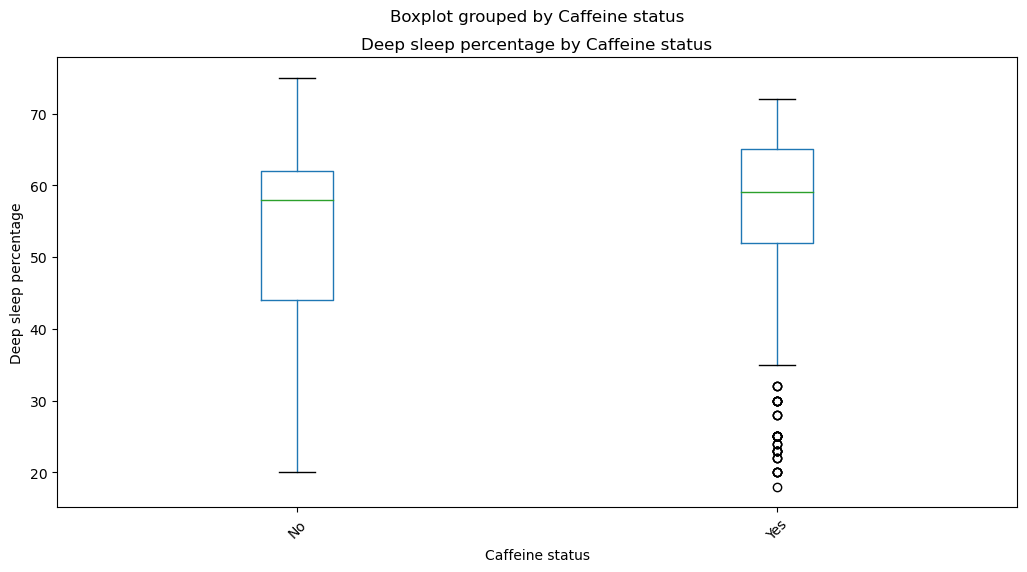

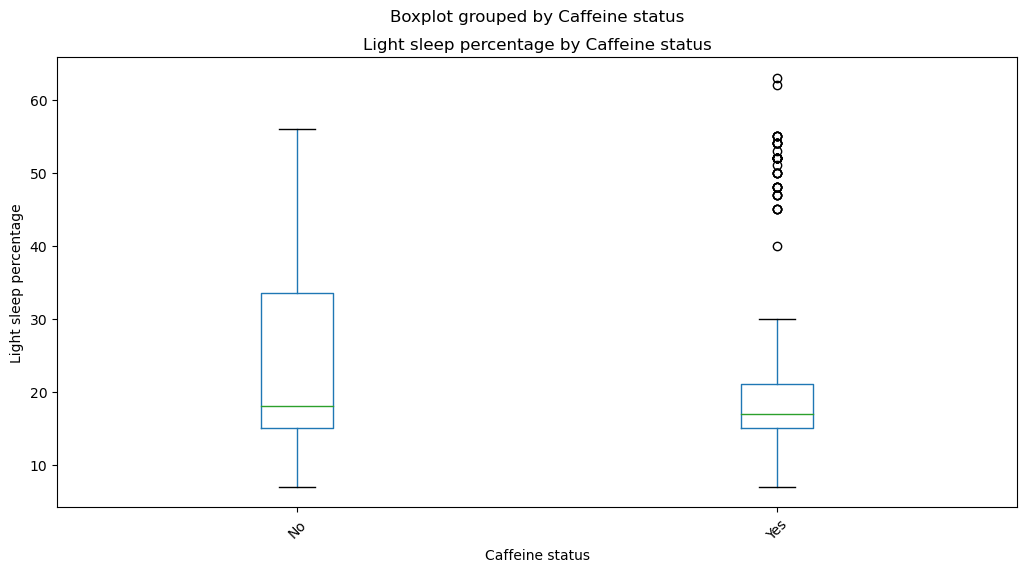

In [23]:
boxplots('Caffeine status')

The boxplots for the two conditions look very similar for all the sleep metrics even for deep and light sleep, although their variabilities are different for those two metrics.

### Regression analysis

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


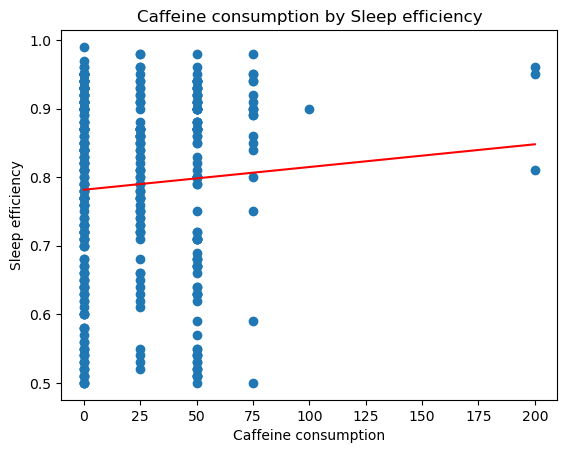

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Sleep efficiency
R^2: 0.0050



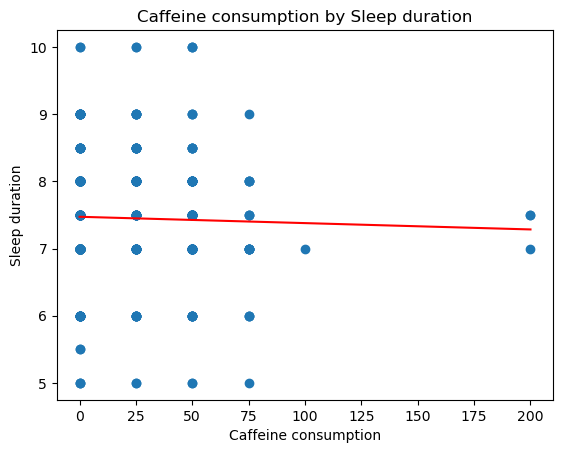

Sleep duration
R^2: 0.0010



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


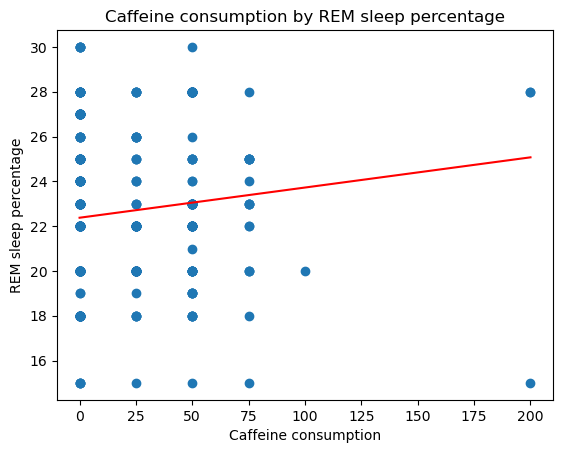

REM sleep percentage
R^2: 0.0130



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


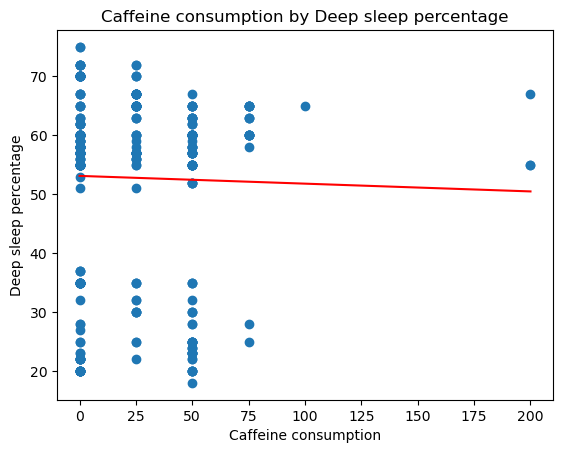

Deep sleep percentage
R^2: 0.0006



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


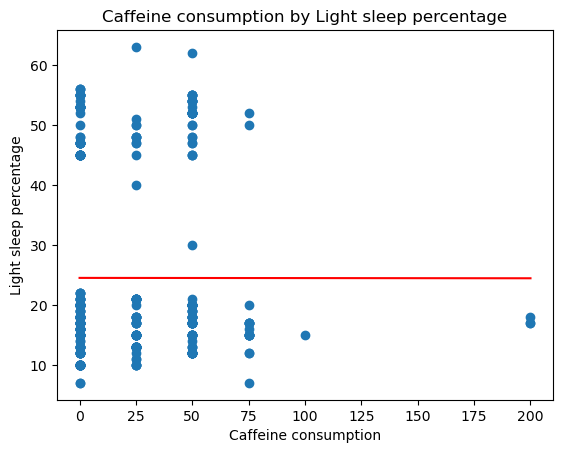

Light sleep percentage
R^2: 0.0000



In [24]:
scatters_cont('Caffeine consumption')

Scatter plots and regression models were created for the different dosages of caffeine the participants used for the different metrics. All models have very low R^2 values, indicating a lack of effect of dosage on sleep.

### Statistical tests

In [25]:
tests('Caffeine status')

Sleep efficiency
p-value: 0.604043
Cohen's d: 0.0527

Sleep duration
p-value: 0.531861
Cohen's d: 0.0636

REM sleep percentage
p-value: 0.126190
Cohen's d: 0.1556

Deep sleep percentage
p-value: 0.791204
Cohen's d: -0.0269

Light sleep percentage
p-value: 0.941950
Cohen's d: -0.0074



None of the statistical tests on the effect of caffeine on sleep were significant.

### Conclusion

Overall, the histograms and boxplots did not show much difference between conditions which is supported by the lack of statistically significant results. Likewise, the regression analysis produced very low  R^2 values, suggesting that the dosage of caffeine does not impact sleep.

# Alcohol

### Histograms

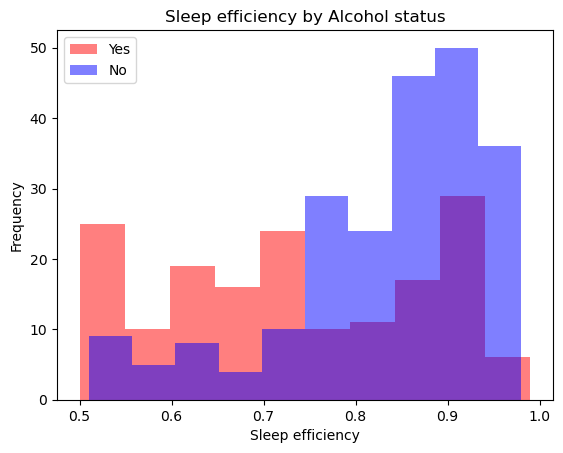

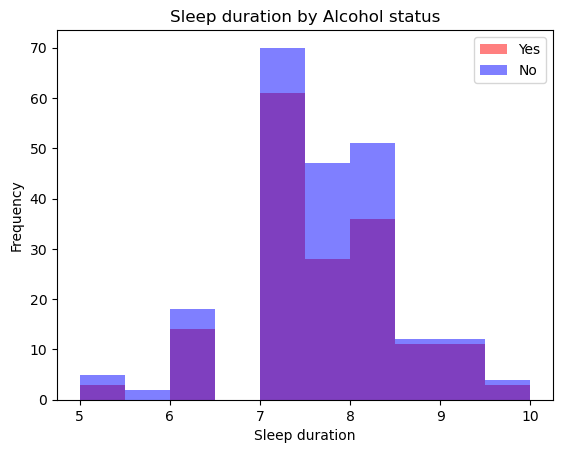

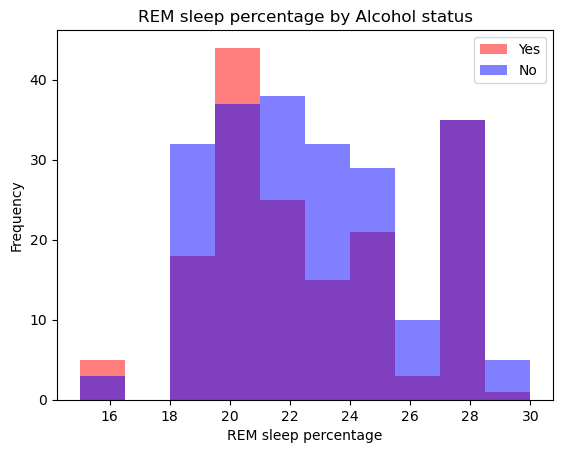

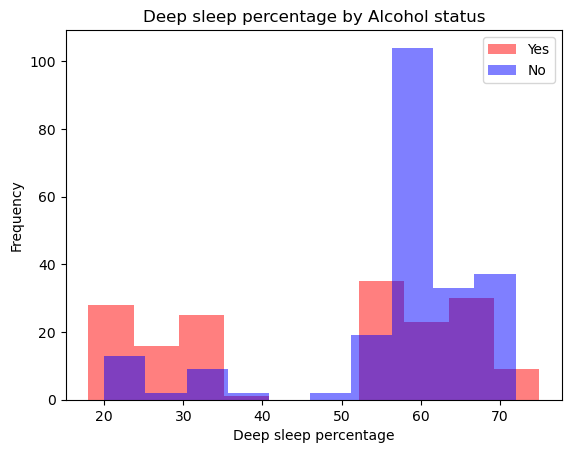

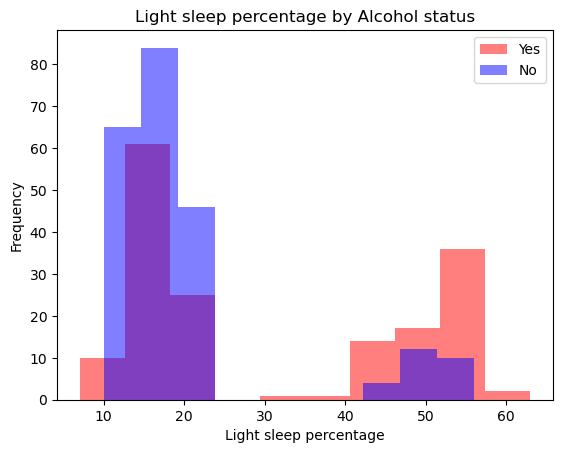

In [26]:
histograms('Alcohol status')

The distribution of people who consumed alcohol is skewed more towards having less sleep efficiency. The histograms overlap for sleep duration and REM sleep. There appears to be a slightly higher proportion of alcohol consumers who experience less deep sleep and more light sleep.

### Boxplots

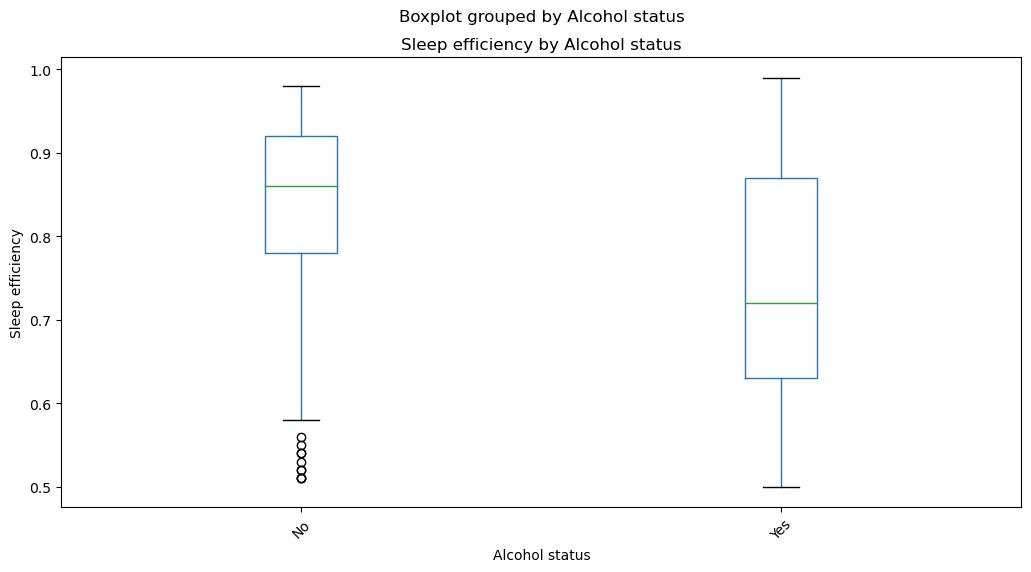

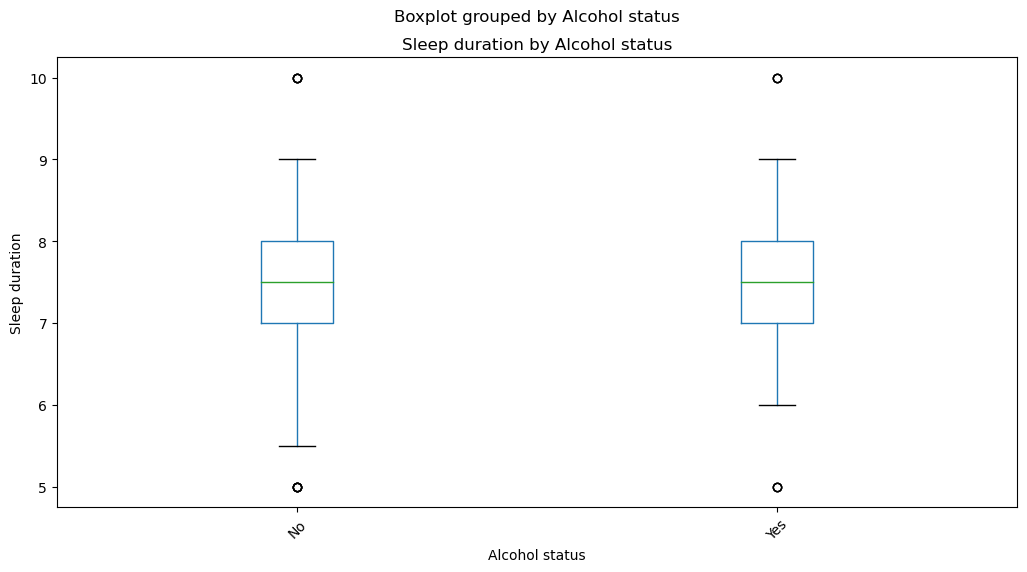

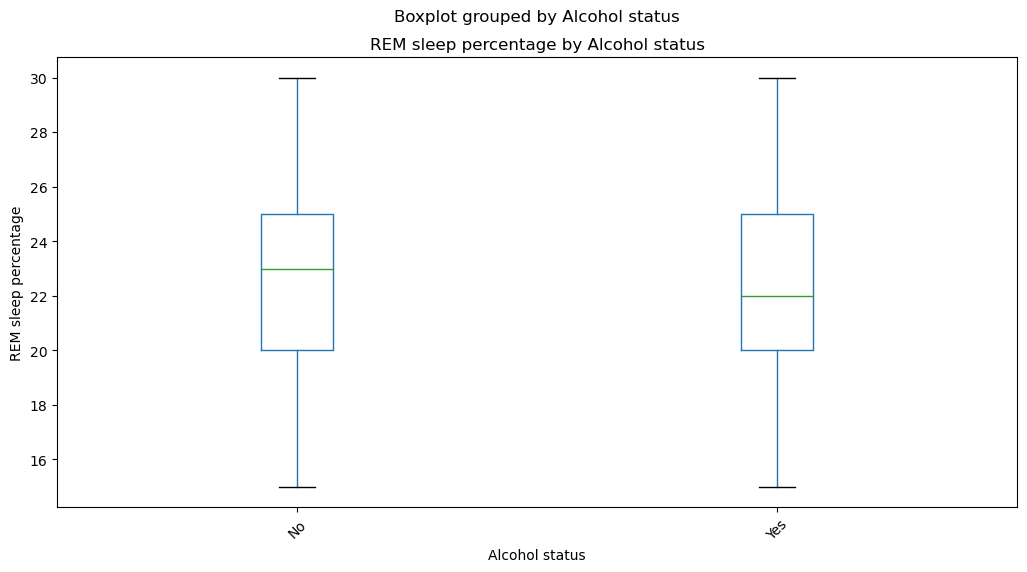

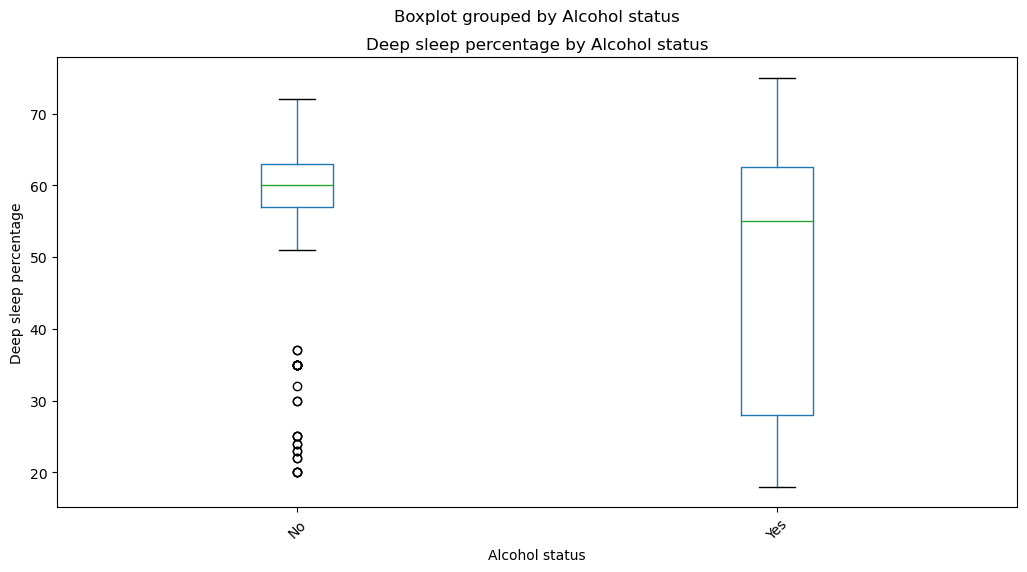

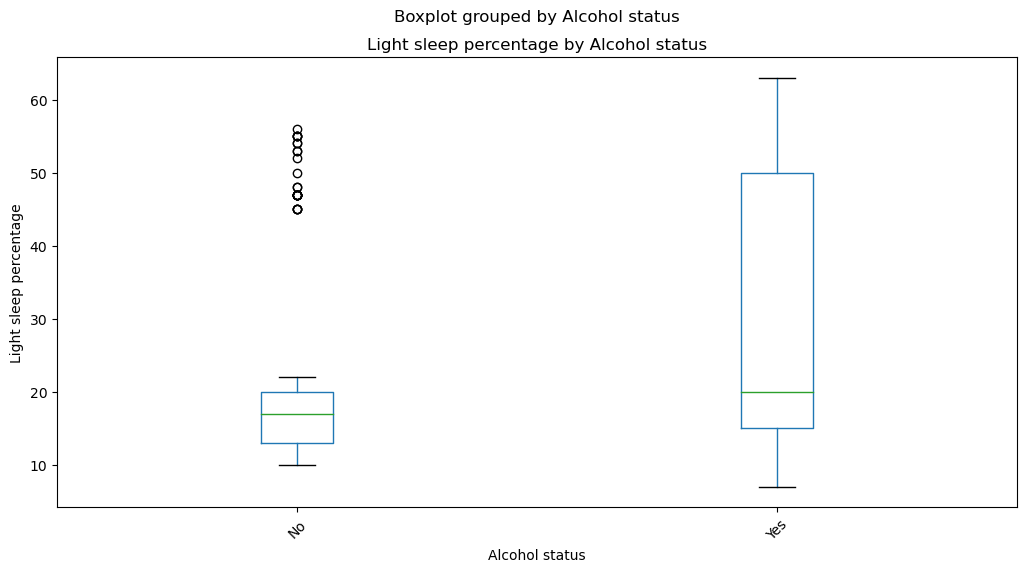

In [27]:
boxplots('Alcohol status')

It looks like the box for people who drink alcohol is lower than for the people who do not drink for sleep efficiency. The boxes for sleep duration and REM sleep are similar. People who do not drink potentially spend more time in deep sleep and less time in light sleep compared to people who do.

### Regression analysis

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


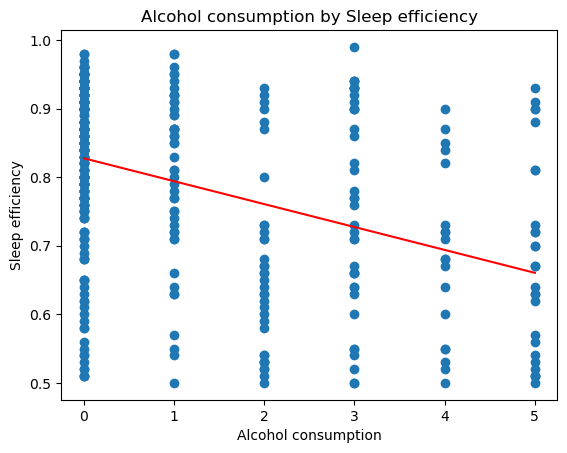

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Sleep efficiency
R^2: 0.1576



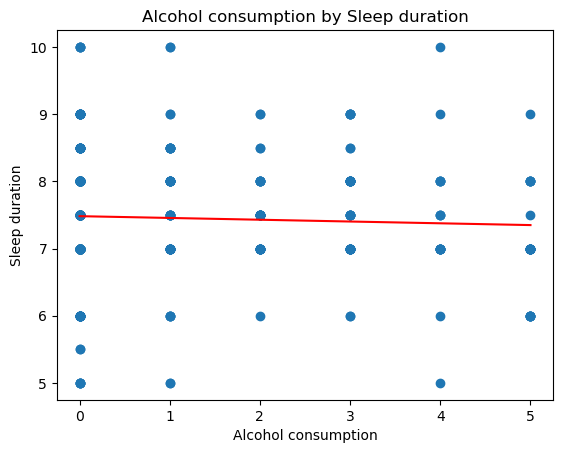

Sleep duration
R^2: 0.0023



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


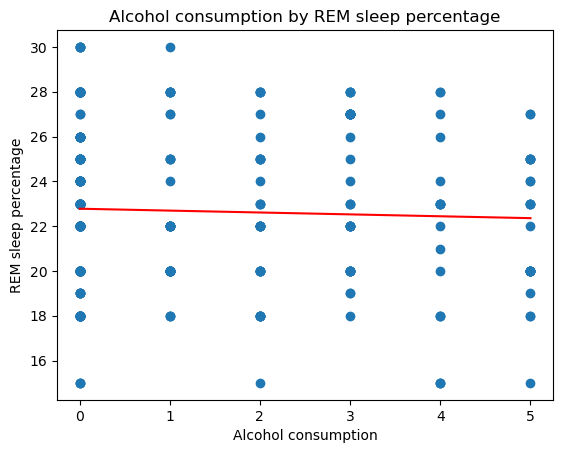

REM sleep percentage
R^2: 0.0016



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


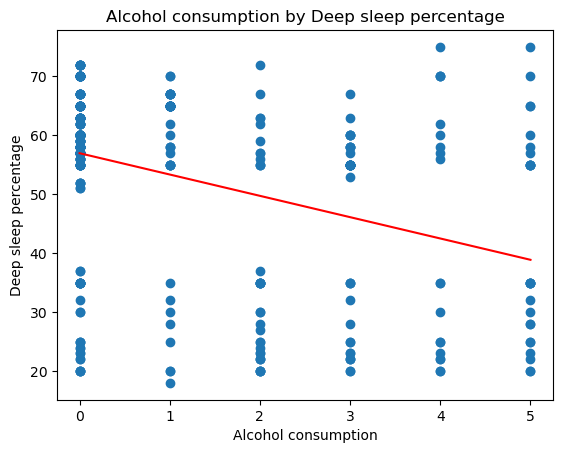

Deep sleep percentage
R^2: 0.1403



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


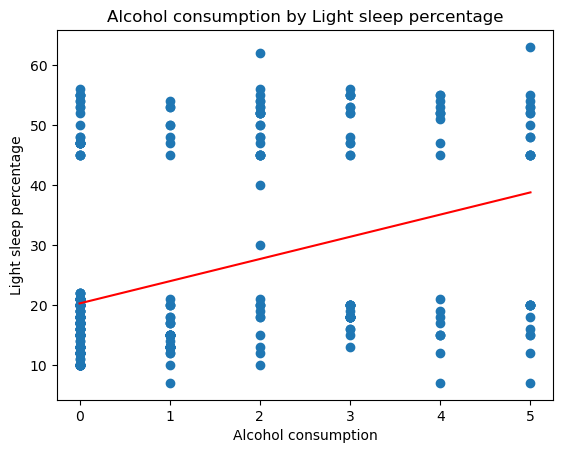

Light sleep percentage
R^2: 0.1520



In [28]:
scatters_cont('Alcohol consumption')

There appears to be a weak negative correlation (R^2 = 0.16) between the number of drinks consumed and sleep efficiency, supporting that more drinks negatively impact sleep.

The R^2 values for sleep duration and REM sleep are very small, suggesting no correlation.

There is a weak negative correlation for deep sleep (R^2 = 0.14) and a weak positive correlation for light sleep (0.15).

### Statistical tests

In [29]:
tests('Alcohol status')

Sleep efficiency
p-value: 0.000000
Cohen's d: -0.7928

Sleep duration
p-value: 0.800641
Cohen's d: 0.0259

REM sleep percentage
p-value: 0.481379
Cohen's d: -0.0724

Deep sleep percentage
p-value: 0.000000
Cohen's d: -0.7239

Light sleep percentage
p-value: 0.000000
Cohen's d: 0.7575



There is a significant difference in the effect of alcohol on sleep efficiency with a large effect (d = -0.79). Since the Cohen's d value is negative, this means that people who consume alcohol have less sleep efficiency.

There is a significant difference in deep and light sleep with Cohen's d values -0.72 and .76 respectively, indicating that people who consume alcohol spend less time in deep sleep and more time in light sleep.

There is no significant effect on sleep duration or time spent in REM sleep.

### Conclusion

Overall, the consumption of alcohol has a pretty significant impact on sleep efficiency and it seems to reduce the time spent in deep sleep and increase the time spent in light sleep. There is a correlation between the amount of drinks consumed and the degree to which efficiency, deep, and light sleep are impacted, indicating that more drinks make things worse.

# Gender

### Histograms

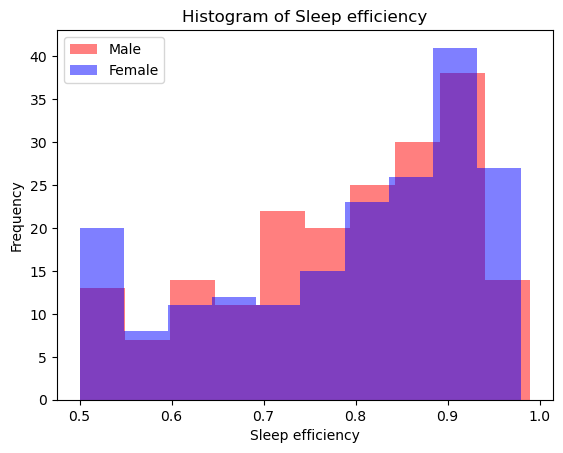

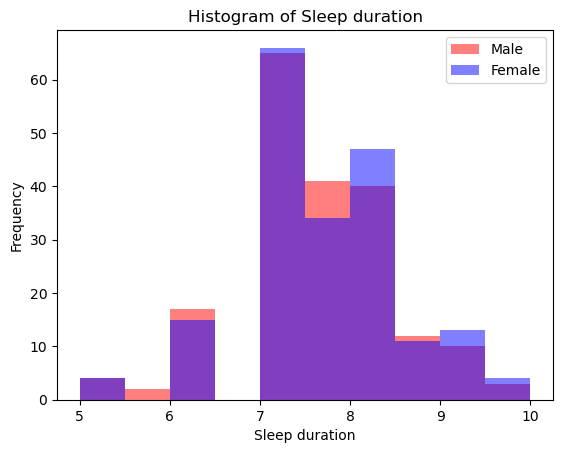

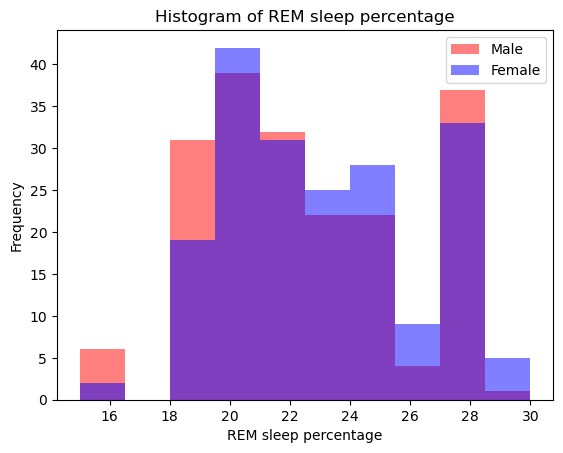

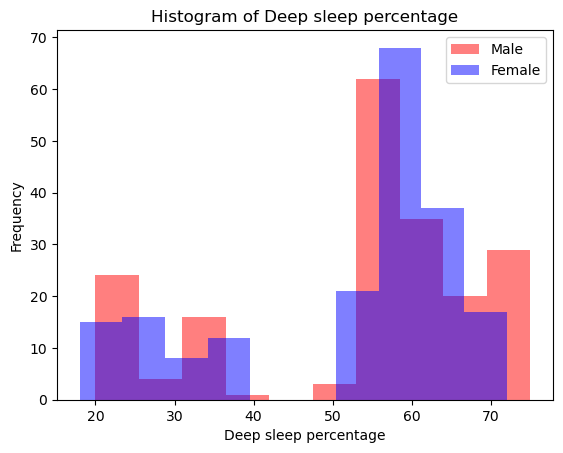

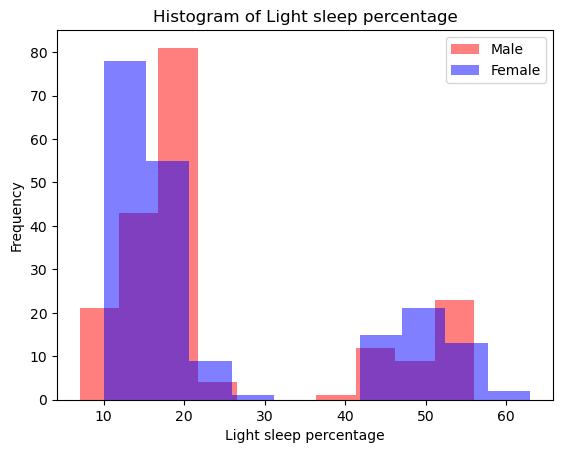

In [30]:
for col in metric:
    male_data = data[data['Gender'] == 'Male'][col]
    female_data = data[data['Gender'] == 'Female'][col]
    plt.hist(male_data,bins = 10, color='red',label='Male',alpha=0.5)
    plt.hist(female_data,bins = 10, color='blue',label='Female',alpha=0.5)
    plt.title('Histogram of '+col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Overlapping histograms corresponding to each gender, for each sleep metric were generated. All histograms show a strong degree of overlap, indicating very little difference.

### Boxplots

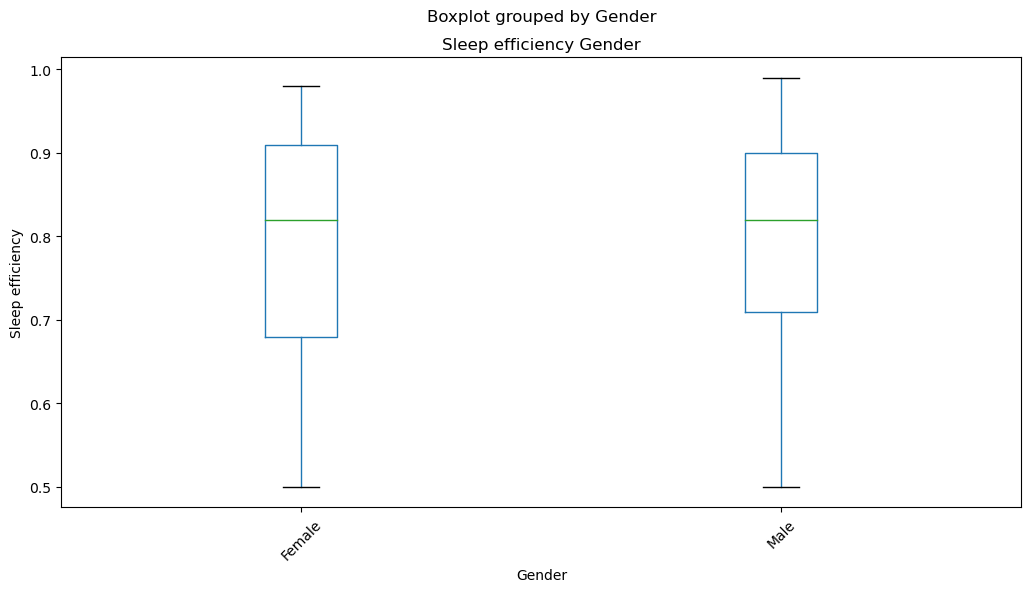

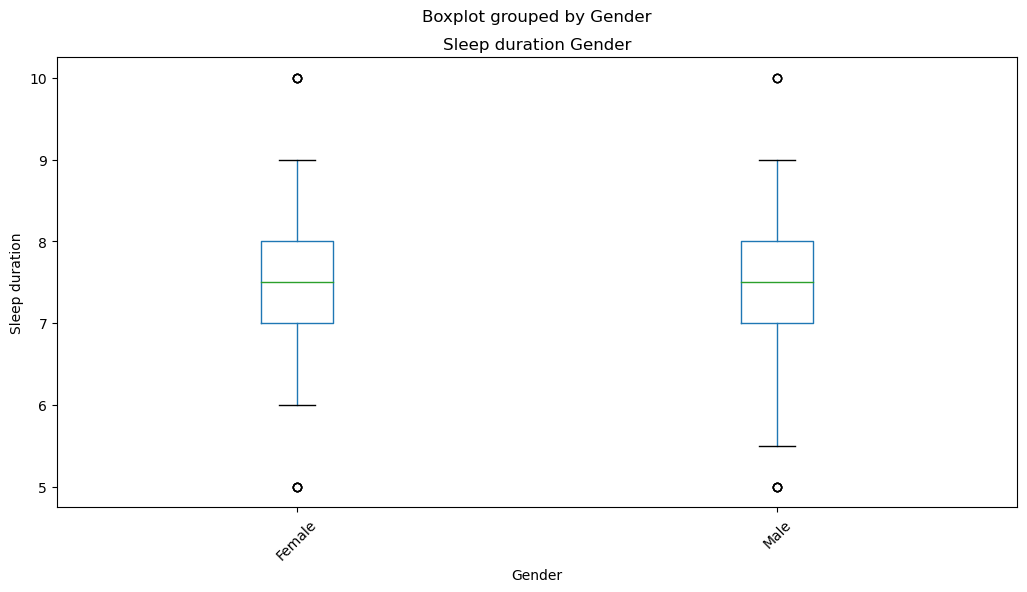

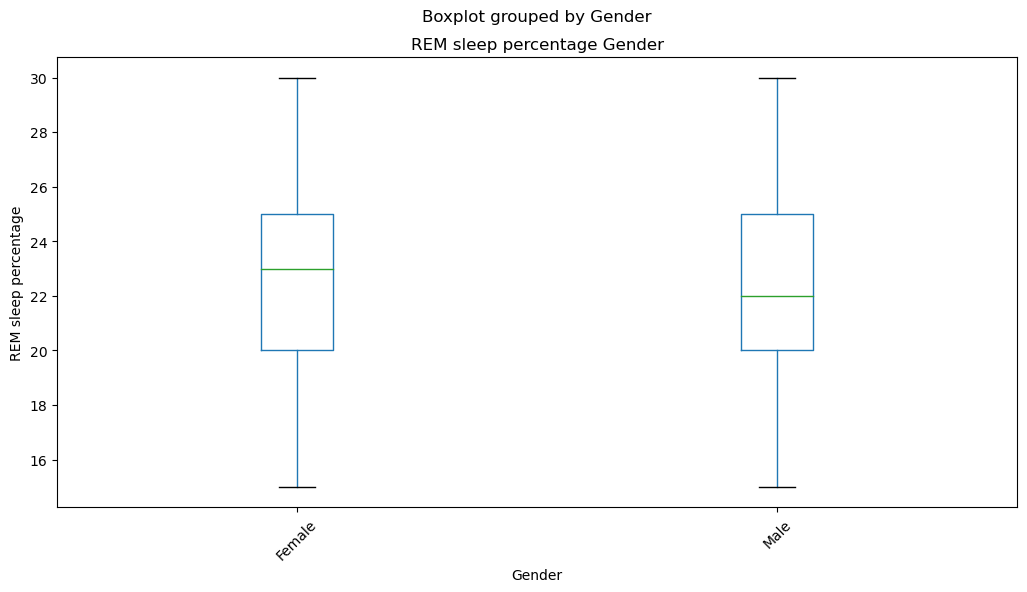

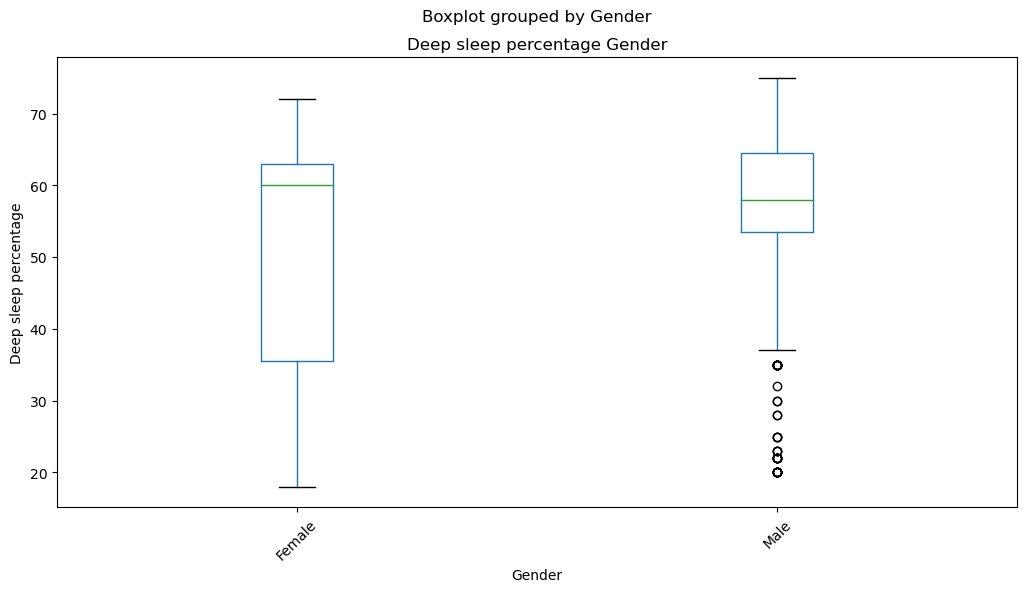

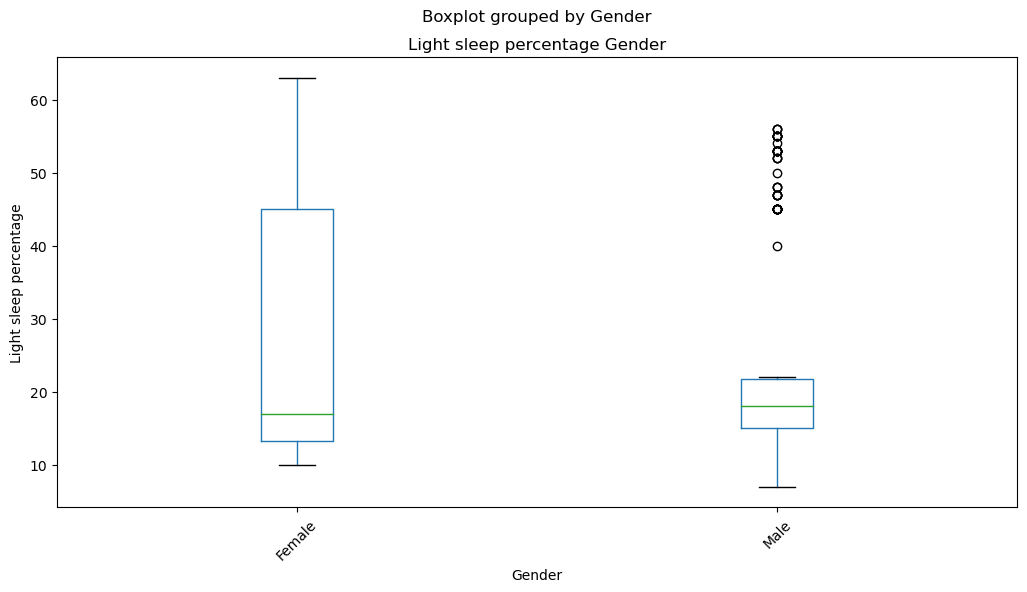

In [31]:
comp = 'Gender'
for col in metric:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax = data.boxplot(column=col, by=comp, ax=ax)
    ax.set_title(col+' '+comp)
    ax.set_xlabel(comp)
    ax.set_ylabel(col)
    plt.xticks(rotation=45)
    ax.grid(False)
    plt.show()

Boxplots were generated comparing the two genders for the different metrics. There appears to be little difference except for deep and light sleep, but the appearance of outliers suggests that this is just due to the split distributions.

### Statistical tests

In [32]:
for col in metric:
    _, p_value = ttest_ind(data[data['Gender']=='Male'][col], 
          data[data['Gender']=='Female'][col],
         equal_var = False)
    effect_size = cohen_d(data[data['Gender']=='Male'][col], 
          data[data['Gender']=='Female'][col])
    print(f"{col}\np-value: {p_value:.6f}")
    print(f"Cohen's d: {effect_size:.4f}\n")

Sleep efficiency
p-value: 0.872447
Cohen's d: -0.0163

Sleep duration
p-value: 0.358555
Cohen's d: -0.0933

REM sleep percentage
p-value: 0.035433
Cohen's d: -0.2143

Deep sleep percentage
p-value: 0.346741
Cohen's d: 0.0957

Light sleep percentage
p-value: 0.626553
Cohen's d: -0.0494



The only metric that is significant is REM sleep percentage. The Cohen's d value is -0.21 which indicates that males spend slightly less time in REM sleep, however, the magnitude is small which indicates a weak effect.

### Conclusion

Overall based on these tests and the plots, there is not strong evidence to support there being much of a difference between males and females, except for a possible difference in the percent time spent in REM sleep.

# Age

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


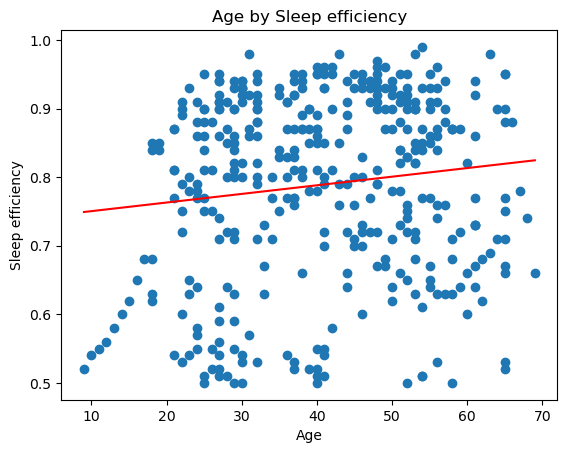

Sleep efficiency
R^2: 0.0154



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


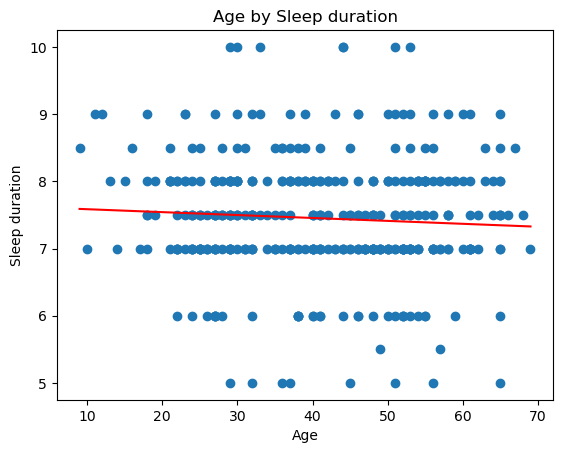

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Sleep duration
R^2: 0.0043



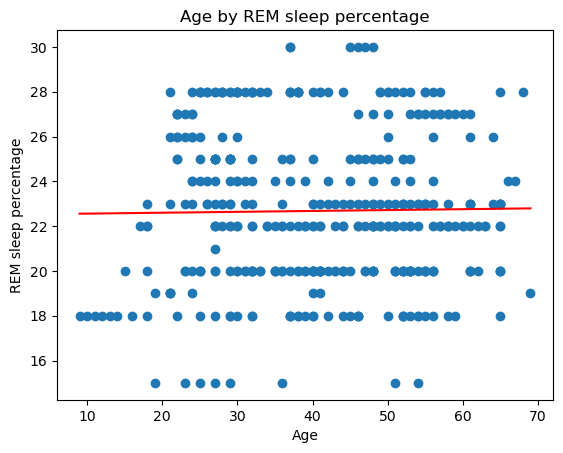

REM sleep percentage
R^2: 0.0002



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


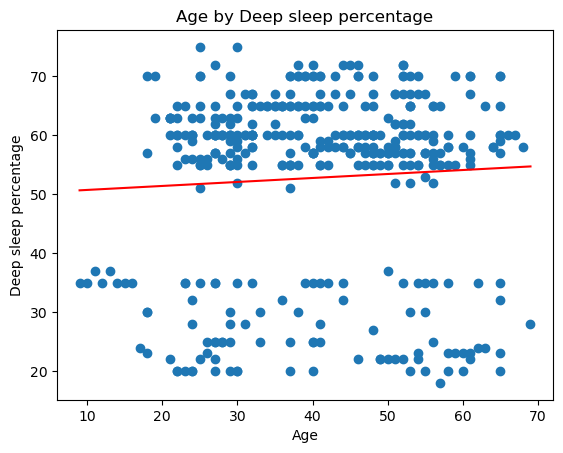

Deep sleep percentage
R^2: 0.0034



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


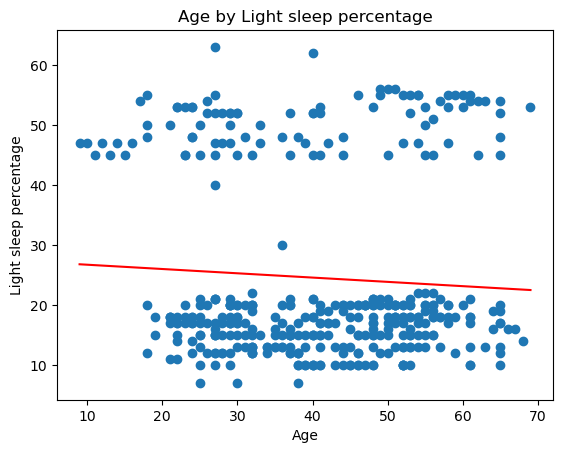

Light sleep percentage
R^2: 0.0039



In [33]:
scatters_cont('Age')

The strongest correlation of age with one of the metrics is with sleep efficiency, but the R^2 value is a measly 0.015. This indicates that age does not impact sleep, which is surprising considering that there is previous research indicating that sleep efficiency declines with age.

# Exercise

### Boxplots

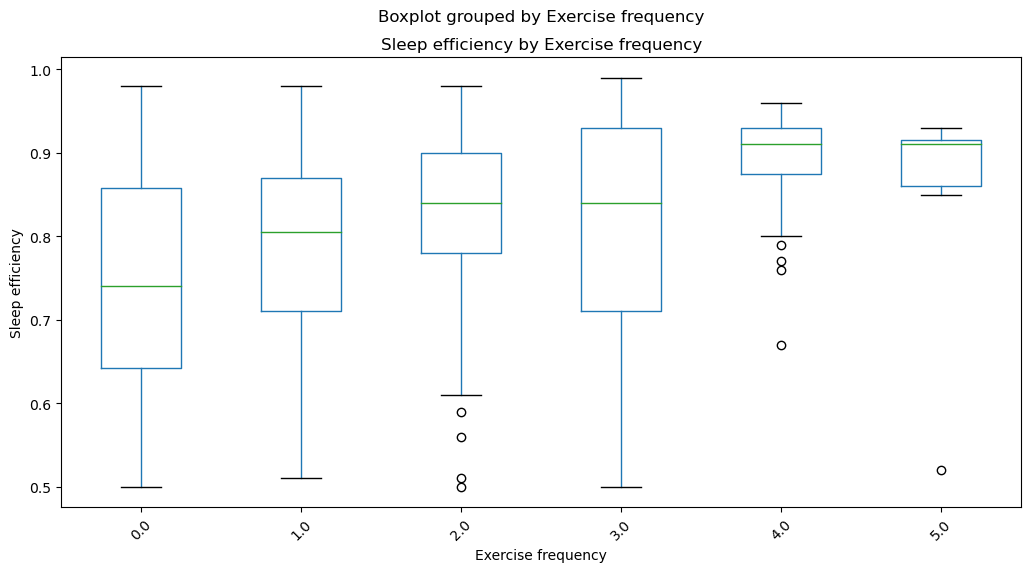

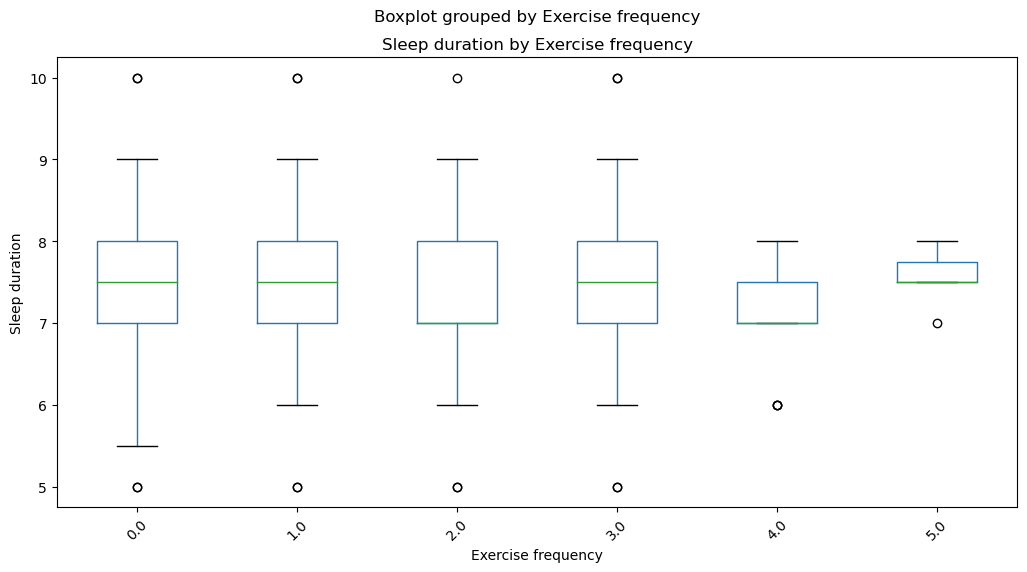

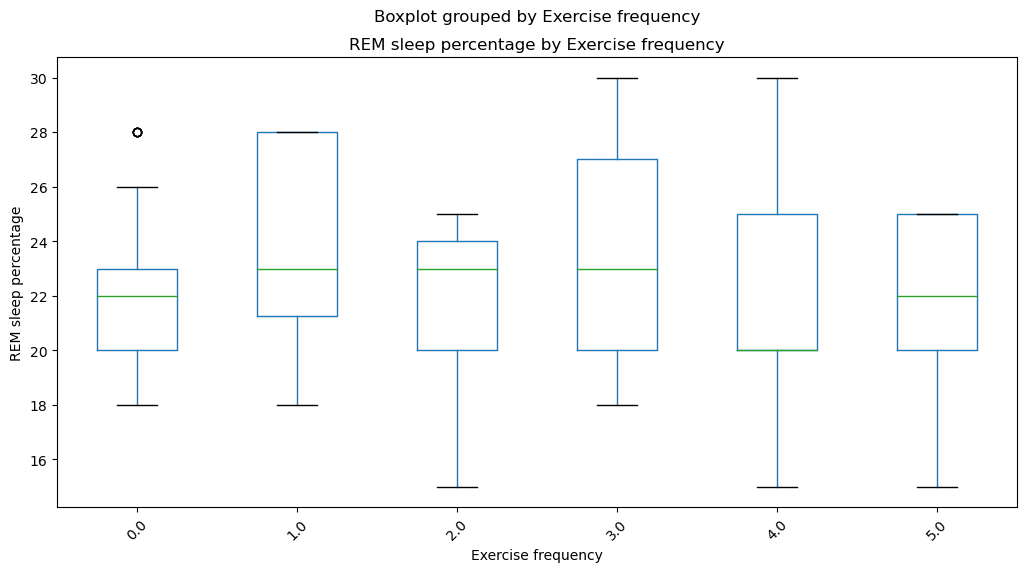

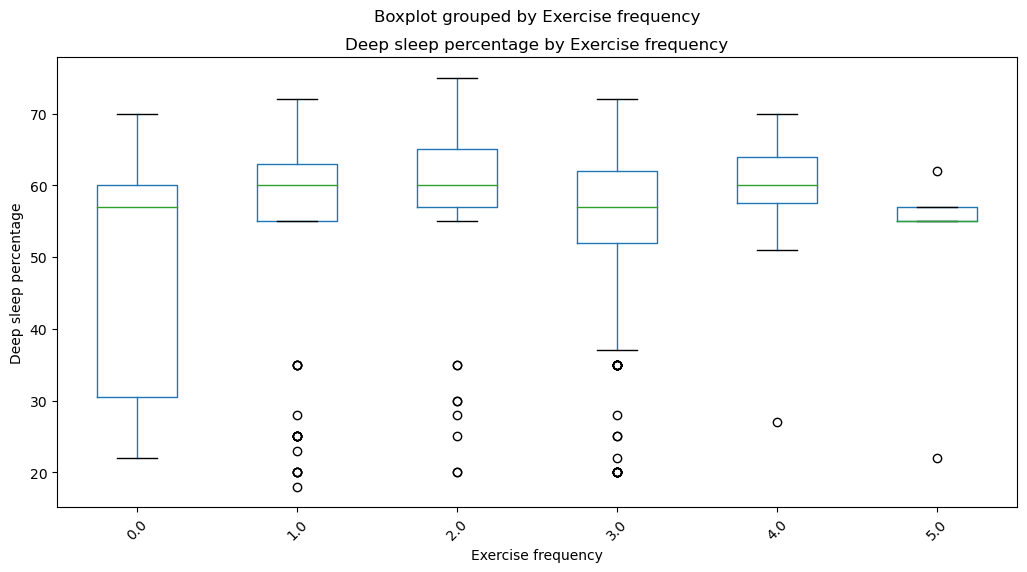

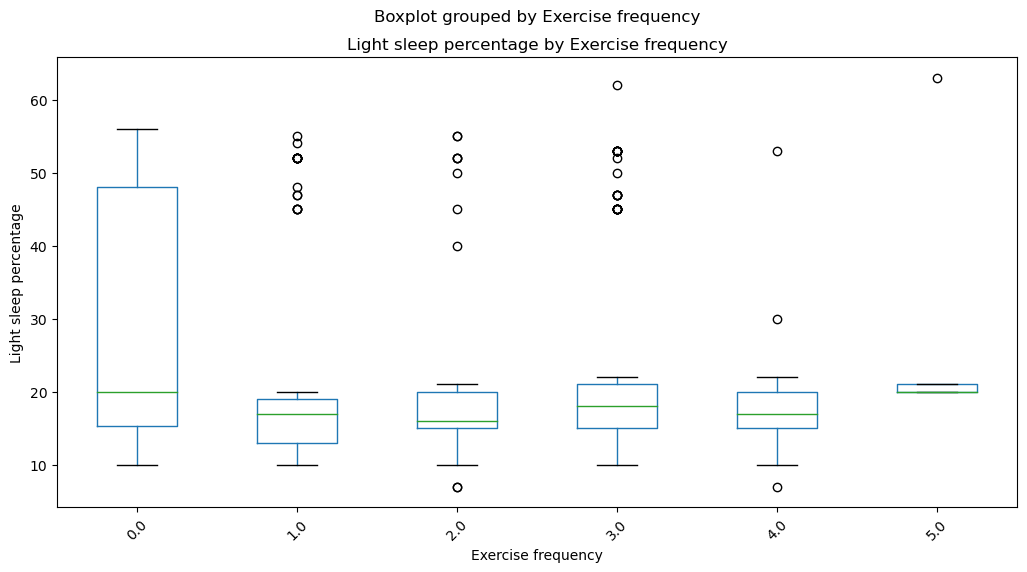

In [34]:
boxplots('Exercise frequency')

For sleep efficiency, it looks as if sleep efficiency increases for more time spent exercising, although the increase tapers off near the highest levels of exercise.

The boxplots for sleep duration and time spent in REM sleep do not appear to be very different.

The boxplots for indicate that exercise might be associated with more time in deep sleep and less time in light sleep.

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


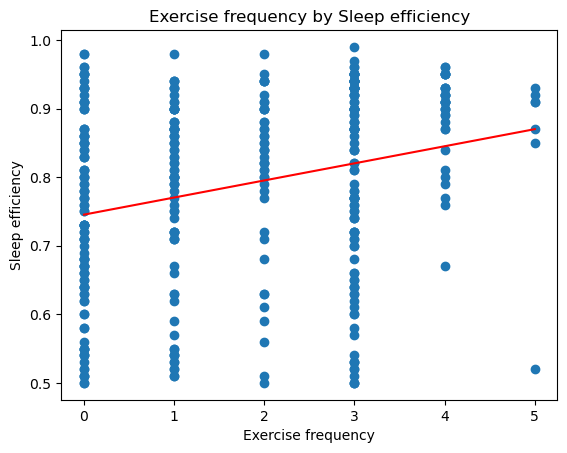

Sleep efficiency
R^2: 0.0708



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


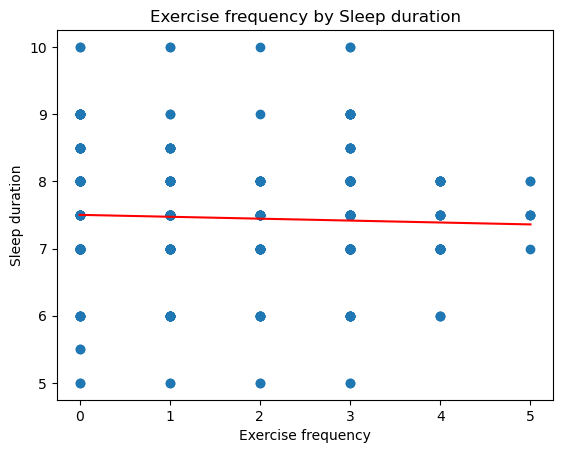

Sleep duration
R^2: 0.0022



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


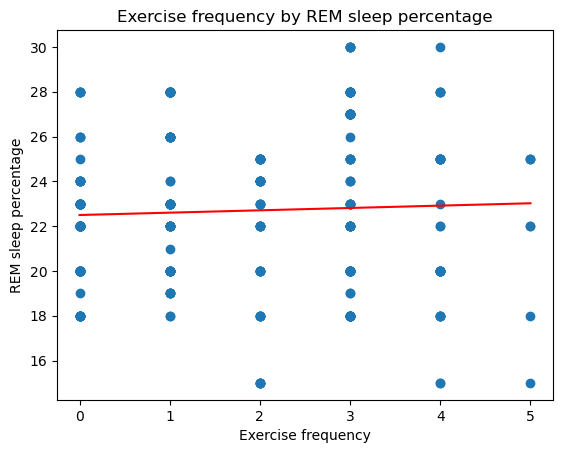

REM sleep percentage
R^2: 0.0020



C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


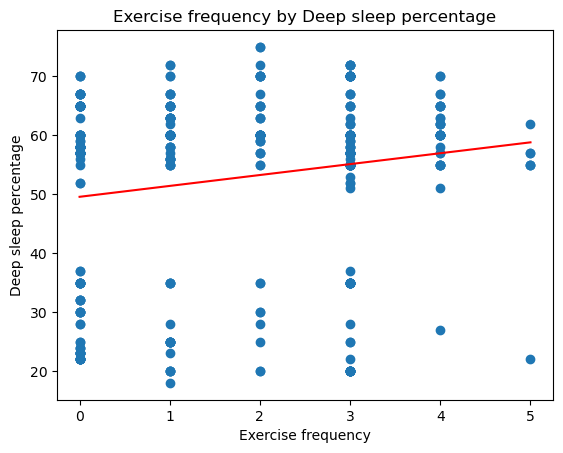

C:\Users\Atomi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Deep sleep percentage
R^2: 0.0295



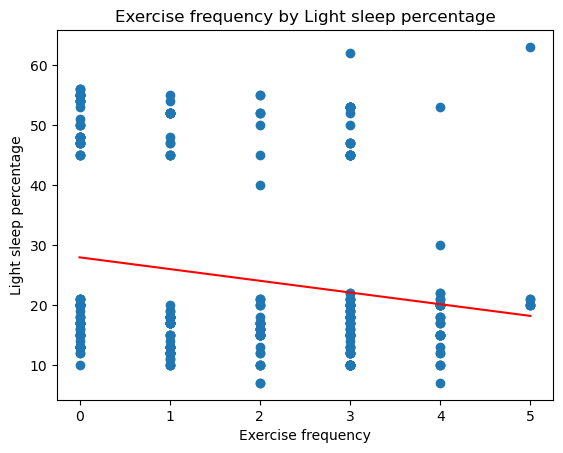

Light sleep percentage
R^2: 0.0341



In [35]:
scatters_cont('Exercise frequency')

The strongest correlation of exercise frequency is with sleep efficiency, although the R^2 value is very low at 0.07.

In [36]:
for col in metric:
    _, p = f_oneway(data[data['Exercise frequency']==0][col],
                   data[data['Exercise frequency']==1][col],
                   data[data['Exercise frequency']==2][col],
                   data[data['Exercise frequency']==3][col],
                   data[data['Exercise frequency']==4][col],
                   data[data['Exercise frequency']==5][col])
    print(f"{col} p-value: {p:.6f}")

Sleep efficiency p-value: 0.000001
Sleep duration p-value: 0.109906
REM sleep percentage p-value: 0.000113
Deep sleep percentage p-value: 0.001209
Light sleep percentage p-value: 0.000292


Anovas were run on the different sleep metrics with only sleep duration being nonsignificant. This means that all metrics other than sleep duration have at least one group that is significantly different from each other.

### Tukey-HSD

In [37]:
for col in metric:
    if col != 'Sleep duration':
        res = tukey_hsd(data[data['Exercise frequency']==0][col], 
                     data[data['Exercise frequency']==1][col],
                     data[data['Exercise frequency']==2][col],
                     data[data['Exercise frequency']==3][col],
                     data[data['Exercise frequency']==4][col],
                     data[data['Exercise frequency']==5][col])
        print(col)
        print(res)

Sleep efficiency
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.030     0.618    -0.086     0.025
 (0 - 2)     -0.065     0.054    -0.131     0.001
 (0 - 3)     -0.054     0.024    -0.104    -0.004
 (0 - 4)     -0.145     0.000    -0.218    -0.073
 (0 - 5)     -0.099     0.368    -0.245     0.046
 (1 - 0)      0.030     0.618    -0.025     0.086
 (1 - 2)     -0.035     0.703    -0.105     0.035
 (1 - 3)     -0.024     0.809    -0.079     0.031
 (1 - 4)     -0.115     0.000    -0.191    -0.039
 (1 - 5)     -0.069     0.759    -0.216     0.078
 (2 - 0)      0.065     0.054    -0.001     0.131
 (2 - 1)      0.035     0.703    -0.035     0.105
 (2 - 3)      0.011     0.997    -0.055     0.077
 (2 - 4)     -0.080     0.072    -0.164     0.004
 (2 - 5)     -0.034     0.988    -0.186     0.118
 (3 - 0)      0.054     0.024     0.004     0.104
 (3 - 1)      0.024     0.809    -0.031     0.079
 (3 - 2)     -0

Tukey-HSD was run as a post-hoc analysis for the metrics that were significant in the anova analysis to see pairwise comparisons.


The statistically significant comparisons are:

Sleep efficiency

Comparison  Statistic,  p-value,  Lower CI,  Upper CI

(0 - 3)     -0.054     0.024    -0.104    -0.004

(0 - 4)     -0.145     0.000    -0.218    -0.073

(1 - 4)     -0.115     0.000    -0.191    -0.039

(3 - 4)     -0.091     0.005    -0.163    -0.019


REM sleep percentage

(0 - 1)     -2.050     0.001    -3.467    -0.634

(0 - 3)     -1.375     0.027    -2.656    -0.094

(1 - 2)      2.256     0.005     0.466     4.047


Deep sleep percentage

(0 - 2)     -8.558     0.020   -16.296    -0.819

(0 - 4)    -11.634     0.001   -20.121    -3.147


Light sleep percentage

(0 - 1)      6.844     0.026     0.506    13.181

(0 - 2)      8.352     0.021     0.775    15.928

(0 - 3)      6.331     0.021     0.597    12.066

(0 - 4)     11.875     0.001     3.566    20.184


Generally speaking, most of the significant comparisons for all metrics are between no exercise and exercise, which is not too surprising. Sleep efficiency and REM sleep are the only ones that had significant differences between the exercise groups.

For sleep efficiency, the no-exercise groups had less sleep efficiency. The two comparisons between exercise groups had the fewer exercise groups experience less sleep efficiency. This suggests that more exercise is associated with greater sleep efficiency.

For REM sleep, the no exercise groups were associated with less time spent in REM sleep, while the lowest exercise group was associated with more time spent in REM sleep than the second exercise group.

For deep and light sleep, the no-exercise groups were associated with less time spent in deep sleep and more time spent in light sleep.

### Conclusion

Overall based on the post hoc analysis and the boxplots it is clear that greater exercise is associated with more sleep efficiency, more deep sleep, and less light sleep. It is surprising that there are significant differences in REM sleep as the groups did not appear to be that different in the plots. It is also interesting the regression R^2 values were so low despite the clear visual differences in the boxplot and the significant results.

# Discussion

These analyses reveal that there are definitely strong associations between lifestyle factors and sleep quality. Sleep quality is ambiguously defined in this analysis, but mostly hinges on sleep efficiency which is the proportion of time spent in bed actually asleep. Sleep efficiency has a strong positive correlation with deep sleep and a strong negative correlation with light sleep. Deep sleep and light sleep have a very strong negative association with each other, indicating that they are intimately related. Any factors that impacted deep sleep impacted light sleep nearly as much, and often impacted sleep efficiency to a similar degree. Because of this deep sleep and light sleep are grouped into the concept of "sleep quality" in this analysis.

The consumption of smoking, caffeine, and alcohol, and their combinations were examined in relation to sleep quality. The consumption of two or all three of those substances together reliably impacted sleep quality in a negative way; although, in the case of only two substances, the pattern of which two substances was inconsistent between sleep metrics. This is clear evidence in support of the idea that combining multiple substances that are known from previous studies to negatively impact sleep leads to an even greater impact on sleep.

When looking at the effects of the substances individually, smoking and alcohol but not caffeine significantly negatively impacted sleep. This is surprising considering the stimulatory and wakefulness promoting nature of caffeine. However, the data does not take into account how many hours before sleep the caffeine was consumed. Caffeine consumed only in the morning is much less likely to affect sleep than if it were taken in the afternoon or evening because it will wear off before sleep. Smoking, on the other hand, is often done throughout the day and close to bed, while alcohol is often consumed in the evening after work. If the data was controlled so that the participants who took caffeine in the afternoon or evening were analyzed, there might be significant results.

Gender does not seem to impact sleep quality at all, with the only metric that was significant was a difference in REM sleep, but with a small effect size. This is not surprising as it is well known that both genders sleep similarly.

Age surprisingly did not have a strong association with any of the sleep metrics, which is surprising considering that there is previous research indicating that sleep efficiency declines with age.

There is a pretty clear association between better sleep quality and having any exercise. While there does appear to be some differences between the amount of exercise on sleep quality, it does not appear to be as impactful as doing any exercise at all. This is encouraging as it means that doing a small amount of exercise can positively impact sleep, which is good for people who do not have the time, energy, or physical capabilities to do large amounts of exercise.

There are some limitations of the original dataset, most prominently with the lack of any information on the frequency of smoking. Information on approximately how much time before sleeping the substances were consumed would have been very useful. While the full dataset of around 450 is pretty large, the sample sizes of the individual groups become much smaller, so increasing the sample size would be useful.

For some future directions, it would be interesting to look at the effect of other health and lifestyle facts such as heart rate, BMI, diet, physical activeness of job, stress, and more.

In conclusion, substance use can reduce sleep quality, gender and age do not have a strong influence on sleep quality, and any amount of exercise can improve sleep quality.